In [0]:
# PySpark SQL
from pyspark.sql.functions import col, when, to_timestamp, month
from pyspark.sql import functions as F
from pyspark.sql.types import NumericType

# PySpark ML
from pyspark.ml import Pipeline
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.feature import (
    StringIndexer, 
    VectorAssembler, 
    StandardScaler,
    PCA
)
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.linalg import VectorUDT

# XGBoost for Spark
from xgboost.spark import SparkXGBClassifier

# MLflow
import mlflow
from mlflow import pyfunc

# Python Data Science Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
import json
from itertools import product
from sklearn.metrics import confusion_matrix

In [0]:
# display(
#     dbutils.fs.ls("dbfs:/student-groups/Group_4_1/")
# )

In [0]:
# 1 Removing duplicates, cancellation flights and column with null values > 12%
ch1 = "dbfs:/student-groups/Group_4_1/otpw_3M_checkpoint_1/"
# 2 Remove data leakage columns and other columns after review
ch2 = "dbfs:/student-groups/Group_4_1/otpw_3M_checkpoint_2/"
# 3 After imputing all the missing columns - new columns included in this step - HourlyPrecipitation_was_missing,wind_deg_imputed, wind_dir_sin,wind_dir_cos
ch3 = "dbfs:/student-groups/Group_4_1/otpw_3M_checkpoint_3/"
# 4 Adding external holiday data
ch4 = "dbfs:/student-groups/Group_4_1/otpw_3M_checkpoint_4/"
# Adding external holiday data, is_weekend, sky_conditions transformed
# one hot encoding of categorical variable
# converted string  to numeric
ch5 = "dbfs:/student-groups/Group_4_1/otpw_3M_checkpoint_5"

In [0]:
# Removing duplicates, cancellation flights, column with null values > 12%  and Data leakage column
yd1 = "dbfs:/student-groups/Group_4_1/otpw_clean_1Y_checkpoint_1/"
# Remove other columns after review
yd2 = "dbfs:/student-groups/Group_4_1/otpw_1Y_checkpoint_2/"
# 3 After imputing all the missing columns - new columns included in this step - HourlyPrecipitation_was_missing,wind_deg_imputed, wind_dir_sin,wind_dir_cos
yd3 = "dbfs:/student-groups/Group_4_1/otpw_1Y_checkpoint_3/"
# Adding external holiday data   new columns included in this step  - HourlyPrecipitation_was_missing,wind_deg_imputed, wind_dir_sin,wind_dir_cos
yd4 = "dbfs:/student-groups/Group_4_1/otpw_1Y_checkpoint_4/"
# Adding external holiday data, is_weekend, sky_conditions transformed
# one hot encoding of categorical variable
# converted string  to numeric
yd5 = "dbfs:/student-groups/Group_4_1/otpw_1Y_checkpoint_5/"

# removed the holiday columns in the process. I’ve added them back now, and all the categorical variables are one-hot encoded with the ohe prefix.
yd7 = "dbfs:/student-groups/Group_4_1/otpw_1Y_checkpoint_7/"

In [0]:
def show_schema_and_sample(path, n=10):
    df = spark.read.parquet(path)
    df.printSchema()
    display(df.limit(n))

show_schema_and_sample(yd7)

root
 |-- HourlyPrecipitation: double (nullable = true)
 |-- HourlySeaLevelPressure: double (nullable = true)
 |-- HourlyAltimeterSetting: double (nullable = true)
 |-- DEP_TIME: integer (nullable = true)
 |-- DEP_DELAY_GROUP: integer (nullable = true)
 |-- HourlyWetBulbTemperature: double (nullable = true)
 |-- HourlyStationPressure: double (nullable = true)
 |-- HourlyWindSpeed: double (nullable = true)
 |-- HourlyRelativeHumidity: double (nullable = true)
 |-- HourlyDewPointTemperature: double (nullable = true)
 |-- HourlyDryBulbTemperature: double (nullable = true)
 |-- HourlyVisibility: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- DATE: timestamp (nullable = true)
 |-- STATION: long (nullable = true)
 |-- two_hours_prior_depart_UTC: timestamp (nullable = true)
 |-- sched_depart_date_time_UTC: timestamp (nullable = true)
 |-- sched_depart_date_time: timestamp (nullable = true)
 |-- DISTANCE_GROUP: integer (nullab

HourlyPrecipitation,HourlySeaLevelPressure,HourlyAltimeterSetting,DEP_TIME,DEP_DELAY_GROUP,HourlyWetBulbTemperature,HourlyStationPressure,HourlyWindSpeed,HourlyRelativeHumidity,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyVisibility,CRS_ARR_TIME,LATITUDE,DATE,STATION,two_hours_prior_depart_UTC,sched_depart_date_time_UTC,sched_depart_date_time,DISTANCE_GROUP,DISTANCE,four_hours_prior_depart_UTC,DAY_OF_MONTH,ORIGIN_AIRPORT_ID,OP_CARRIER_FL_NUM,CRS_DEP_TIME,ELEVATION,dest_airport_lon,DEST_AIRPORT_ID,origin_airport_lon,origin_airport_lat,day_of_week,dest_airport_lat,FL_DATE,QUARTER,LONGITUDE,CRS_ELAPSED_TIME,month,ts,HourlyWindDirection_deg,wind_dir_sin,wind_dir_cos,HourlyPrecipitation_was_missing,has_CLR,CLR_height_ft,has_FEW,FEW_height_ft,has_SCT,SCT_height_ft,has_BKN,BKN_height_ft,has_OVC,OVC_height_ft,ORIGIN_ohe,TAIL_NUM_ohe,DEP_TIME_BLK_ohe,dest_region_ohe,dest_type_ohe,NAME_ohe,origin_region_ohe,origin_type_ohe,origin_iata_code_ohe,dest_iata_code_ohe,is_us_holiday,is_holiday_window,is_summer_peak,season,hour_of_day,is_weekend
0.0,30.23,30.13,1736,1,3.0,28.39,6.0,76.0,-2.0,4.0,10.0,1851,42.2068,2015-02-05T18:53:00Z,72515004725,2015-02-05T20:15:00Z,2015-02-05T22:15:00Z,2015-02-05T17:15:00Z,2,378.0,2015-02-05T18:15:00Z,5,10577,5076,1715,486.2,-83.3,11433,-76.0,42.2,4,42.2,2015-02-05,1,-75.98,96.0,2,2015-02-05T18:53:00Z,300.0,-0.8660254037844386,0.5000000000000001,0,0,0,0,0,0,0,0,0,0,0,"Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 4895, indices -> List(580), values -> List(1.0))","Map(vectorType -> sparse, length -> 19, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 55, indices -> List(10), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 286, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 53, indices -> List(5), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 322, indices -> List(11), values -> List(1.0))",0,0,0,Winter,22,0
0.0,29.88,29.78,1710,0,12.0,28.06,6.0,59.0,3.0,15.0,10.0,1846,42.2068,2015-02-17T18:53:00Z,72515004725,2015-02-17T20:10:00Z,2015-02-17T22:10:00Z,2015-02-17T17:10:00Z,2,378.0,2015-02-17T18:10:00Z,17,10577,5212,1710,486.2,-83.3,11433,-76.0,42.2,2,42.2,2015-02-17,1,-75.98,96.0,2,2015-02-17T18:53:00Z,10.0,0.17364817766693033,0.984807753012208,0,0,0,0,0,0,0,0,0,0,0,"Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 4895, indices -> List(872), values -> List(1.0))","Map(vectorType -> sparse, length -> 19, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 55, indices -> List(10), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 286, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 53, indices -> List(5), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 322, indices -> List(11), values -> List(1.0))",0,1,0,Winter,22,0
0.0,29.67,29.7,1543,0,66.0,27.98,15.0,71.0,62.0,72.0,10.0,1655,42.2068,2015-07-21T15:53:00Z,72515004725,2015-07-21T17:32:00Z,2015-07-21T19:32:00Z,2015-07-21T15:32:00Z,2,378.0,2015-07-21T15:32:00Z,21,10577,5097,1532,486.2,-83.3,11433,-76.0,42.2,2,42.2,2015-07-21,3,-75.98,83.0,7,2015-07-21T15:53:00Z,350.0,-0.1736481776669304,0.984807753012208,0,0,0,0,0,0,0,0,0,0,0,"Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 4895, 

In [0]:
file_locations = {
}

file_location_1y = {
    "1_year_data_weighted_t_b": yd7
}

In [0]:
cols_to_remove = [
    "DEP_DELAY_NEW", "DEP_TIME", "DEP_DELAY", "DEP_DELAY_GROUP",
    "HourlySeaLevelPressure",
    "HourlyStationPressure",
    "HourlyDewPointTemperature",
    "origin_airport_lon",
    "DISTANCE_GROUP",
    "month",
    "wind_dir_cos",
    "DEP_TIME_BLK_ohe",
    "origin_region_ohe",
    "FL_DATE",
    "four_hours_prior_depart_UTC",
    'CRS_ARR_TIME', 'CRS_DEP_TIME',
    'CRS_ELAPSED_TIME'
]

In [0]:
chosen_cols = [
    "HourlyPrecipitation",
    "HourlySeaLevelPressure",
    "HourlyAltimeterSetting",
    # "DEP_TIME",
    "DEP_DELAY_GROUP",
    "HourlyWetBulbTemperature",
    "HourlyStationPressure",
    "HourlyWindSpeed",
    "HourlyRelativeHumidity",
    "HourlyDewPointTemperature",
    "HourlyDryBulbTemperature",
    "HourlyVisibility",
    "LATITUDE",
    # "DISTANCE",
    "DAY_OF_MONTH",
    "ORIGIN_AIRPORT_ID",
    # "OP_CARRIER_FL_NUM",
    # "ELEVATION",
    "DEST_AIRPORT_ID",
    "origin_airport_lon",
    "origin_airport_lat",
    "day_of_week",
    # "dest_airport_lat",
    # "FL_DATE",
    # "QUARTER",
    "LONGITUDE",
    # "CRS_ELAPSED_TIME",
    # "month",
    # "HourlyWindDirection_deg",
    "wind_dir_sin",
    "wind_dir_cos",
    # "HourlyPrecipitation_was_missing",
    # "ORIGIN_ohe",
    # "TAIL_NUM_ohe",
    # "origin_region_ohe",
    "is_us_holiday",
    "is_holiday_window",
    "is_summer_peak",
    "season",
    "hour_of_day",
    "is_weekend"
]

In [0]:
def load_df(file_dict):
    dfs = []
    for key, file_location in file_dict.items():
        try:
            if len(dbutils.fs.ls(file_location)) > 0:
                dfs.append({"name": key, "df": spark.read.parquet(file_location)})
            else:
                print(f"Skipping empty path: {file_location}")
        except Exception as e:
            print(f"Skipping invalid path: {file_location} ({e})")
    return dfs

dfs_1y = load_df(file_location_1y)

In [0]:
for i, item in enumerate(dfs_1y):
    print(f"First 10 rows of dfs_1y[{i}]:")
    display(item["df"].limit(10))

First 10 rows of dfs_1y[0]:


HourlyPrecipitation,HourlySeaLevelPressure,HourlyAltimeterSetting,DEP_TIME,DEP_DELAY_GROUP,HourlyWetBulbTemperature,HourlyStationPressure,HourlyWindSpeed,HourlyRelativeHumidity,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyVisibility,CRS_ARR_TIME,LATITUDE,DATE,STATION,two_hours_prior_depart_UTC,sched_depart_date_time_UTC,sched_depart_date_time,DISTANCE_GROUP,DISTANCE,four_hours_prior_depart_UTC,DAY_OF_MONTH,ORIGIN_AIRPORT_ID,OP_CARRIER_FL_NUM,CRS_DEP_TIME,ELEVATION,dest_airport_lon,DEST_AIRPORT_ID,origin_airport_lon,origin_airport_lat,day_of_week,dest_airport_lat,FL_DATE,QUARTER,LONGITUDE,CRS_ELAPSED_TIME,month,ts,HourlyWindDirection_deg,wind_dir_sin,wind_dir_cos,HourlyPrecipitation_was_missing,has_CLR,CLR_height_ft,has_FEW,FEW_height_ft,has_SCT,SCT_height_ft,has_BKN,BKN_height_ft,has_OVC,OVC_height_ft,ORIGIN_ohe,TAIL_NUM_ohe,DEP_TIME_BLK_ohe,dest_region_ohe,dest_type_ohe,NAME_ohe,origin_region_ohe,origin_type_ohe,origin_iata_code_ohe,dest_iata_code_ohe,is_us_holiday,is_holiday_window,is_summer_peak,season,hour_of_day,is_weekend
0.0,30.23,30.13,1736,1,3.0,28.39,6.0,76.0,-2.0,4.0,10.0,1851,42.2068,2015-02-05T18:53:00Z,72515004725,2015-02-05T20:15:00Z,2015-02-05T22:15:00Z,2015-02-05T17:15:00Z,2,378.0,2015-02-05T18:15:00Z,5,10577,5076,1715,486.2,-83.3,11433,-76.0,42.2,4,42.2,2015-02-05,1,-75.98,96.0,2,2015-02-05T18:53:00Z,300.0,-0.8660254037844386,0.5000000000000001,0,0,0,0,0,0,0,0,0,0,0,"Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 4895, indices -> List(580), values -> List(1.0))","Map(vectorType -> sparse, length -> 19, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 55, indices -> List(10), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 286, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 53, indices -> List(5), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 322, indices -> List(11), values -> List(1.0))",0,0,0,Winter,22,0
0.0,29.88,29.78,1710,0,12.0,28.06,6.0,59.0,3.0,15.0,10.0,1846,42.2068,2015-02-17T18:53:00Z,72515004725,2015-02-17T20:10:00Z,2015-02-17T22:10:00Z,2015-02-17T17:10:00Z,2,378.0,2015-02-17T18:10:00Z,17,10577,5212,1710,486.2,-83.3,11433,-76.0,42.2,2,42.2,2015-02-17,1,-75.98,96.0,2,2015-02-17T18:53:00Z,10.0,0.17364817766693033,0.984807753012208,0,0,0,0,0,0,0,0,0,0,0,"Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 4895, indices -> List(872), values -> List(1.0))","Map(vectorType -> sparse, length -> 19, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 55, indices -> List(10), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 286, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 53, indices -> List(5), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 322, indices -> List(11), values -> List(1.0))",0,1,0,Winter,22,0
0.0,29.67,29.7,1543,0,66.0,27.98,15.0,71.0,62.0,72.0,10.0,1655,42.2068,2015-07-21T15:53:00Z,72515004725,2015-07-21T17:32:00Z,2015-07-21T19:32:00Z,2015-07-21T15:32:00Z,2,378.0,2015-07-21T15:32:00Z,21,10577,5097,1532,486.2,-83.3,11433,-76.0,42.2,2,42.2,2015-07-21,3,-75.98,83.0,7,2015-07-21T15:53:00Z,350.0,-0.1736481776669304,0.984807753012208,0,0,0,0,0,0,0,0,0,0,0,"Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 4895, 

In [0]:
PCA_columns = [
    "HourlyPrecipitation",
    "HourlySeaLevelPressure",
    "HourlyAltimeterSetting",
    "HourlyWetBulbTemperature",
    "HourlyStationPressure",
    "HourlyWindDirection",
    "HourlyRelativeHumidity",
    "HourlyDewPointTemperature",
    "HourlyWindSpeed",
    "HourlyDryBulbTemperature",
    "HourlyVisibility",
    "LATITUDE",
    "DISTANCE_GROUP",
    "DISTANCE",
    "CRS_ARR_TIME",
    "DAY_OF_MONTH",
    "ORIGIN_AIRPORT_ID",
    "DEST_AIRPORT_ID",
    "OP_CARRIER_FL_NUM",
    "CRS_DEP_TIME",
    "ELEVATION",
    "origin_airport_lon",
    "origin_airport_lat",
    "dest_airport_lon",
    "dest_airport_lat",
    "LONGITUDE",
    "CRS_ELAPSED_TIME",
    "month",
    "day_of_week",
    "HourlyPrecipitation_was_missing",
    "wind_deg_imputed",
    "wind_dir_sin",
    "wind_dir_cos",
    "is_us_holiday",
    "is_holiday_window",
    "is_summer_peak",
    "hour_of_day",
    "is_weekend",
    "has_CLR",
    "CLR_height_ft",
    "has_FEW",
    "FEW_height_ft",
    "has_SCT",
    "SCT_height_ft",
    "has_BKN",
    "BKN_height_ft",
    "has_OVC",
    "OVC_height_ft"
]

def three_month_modifier_for_pca(df):
    to_double_cols = [
        "DEP_DELAY_NEW", "DEP_TIME", "DEP_DELAY", "DEP_DELAY_GROUP",
        "LATITUDE", "DISTANCE_GROUP", "DISTANCE", "CRS_ARR_TIME",
        "DAY_OF_MONTH", "ORIGIN_AIRPORT_ID", "OP_CARRIER_FL_NUM",
        "CRS_DEP_TIME", "ELEVATION", "DEST_AIRPORT_ID",
        "origin_airport_lon", "origin_airport_lat",
        "dest_airport_lon", "dest_airport_lat",
        "LONGITUDE", "CRS_ELAPSED_TIME", "QUARTER"
    ]

    for c in to_double_cols:
        if c in df.columns:
            df = df.withColumn(c, col(c).cast("double"))

    return df

In [0]:
PCA_1y = [
    "HourlyPrecipitation",
    "HourlySeaLevelPressure",
    "HourlyAltimeterSetting",
    "HourlyWetBulbTemperature",
    "HourlyStationPressure",
    "HourlyWindSpeed",
    "HourlyRelativeHumidity",
    "HourlyDewPointTemperature",
    "HourlyDryBulbTemperature",
    "HourlyVisibility",
    "CRS_ARR_TIME",
    "QUARTER",
    "day_of_week",
    "DAY_OF_MONTH",
    "CRS_DEP_TIME",
    "OP_CARRIER_FL_NUM",
    "dest_airport_lat",
    "ELEVATION",
    "LONGITUDE",
    "LATITUDE",
    "DISTANCE_GROUP",
    "DISTANCE",
    "CRS_ELAPSED_TIME",
    "month",
    "dest_airport_lon",
    "origin_airport_lon",
    "origin_airport_lat",
    "is_us_holiday",
    "is_holiday_window",
    "is_summer_peak",
    "hour_of_day",
    "is_weekend",
    "has_CLR",
    "CLR_height_ft",
    "has_FEW",
    "FEW_height_ft",
    "has_SCT",
    "SCT_height_ft",
    "has_BKN",
    "BKN_height_ft",
    "has_OVC",
    "OVC_height_ft",
    "wind_deg_raw",
    "HourlyWindDirection_deg",
    "wind_dir_sin",
    "wind_dir_cos"
]

In [0]:
target_selected = list(set(chosen_cols + PCA_columns + PCA_1y))

## Main Dataset creation

In [0]:
# Leveraged from Eric
def create_delay_groups(df):
    df_new = df.withColumn(
        "DEP_DELAY_GROUP_CLASSIFIED",
        when(col("DEP_DELAY_GROUP").isin(-2, -1), "not_delayed")
        .when(col("DEP_DELAY_GROUP").isin(0), "not_delayed")
        .otherwise("delayed"),
    )
    return df_new

In [0]:
def prep_for_rf(df, label_col="DEP_DELAY_GROUP_CLASSIFIED"):
    banned = {label_col, "DEP_DELAY_GROUP"}

    # 1) clear any stale ML metadata
    df = df.select([F.col(c).alias(c, metadata={}) for c in df.columns])

    # 2) normalize strings, then cast ALL non-label strings to double
    for c, t in df.dtypes:
        if t == "string" and c not in banned:
            df = df.withColumn(c, F.trim(F.col(c)))
            df = df.withColumn(c, F.when(F.col(c) == "", None).otherwise(F.col(c)))
            df = df.withColumn(c, F.col(c).cast("double"))  # non-numeric → null

    # 3) fill NaNs in numerics (so assembler/RF won’t choke)
    numeric_cols = [c for c, t in df.dtypes if c not in banned and t in {"double","float","int","bigint"}]
    if numeric_cols:
        df = df.fillna(0.0, subset=numeric_cols)
    else:
        raise ValueError("Still no numeric columns after casting — check schema/label name.")

    return df

In [0]:
## SPLIT_FN
def train_test_split(df, *args):
    # Train / test split
    train_df, test_df = df.randomSplit([0.8, 0.2], seed=1234)
    return train_df, test_df

def month_split(df, min_month, max_month):
    """ month split train/eval and test/predict - greater than and equal to max month"""
    train_df = df.filter(month(to_timestamp(col("DATE"))) <= min_month)
    test_df = df.filter(month(to_timestamp(col("DATE"))) >= max_month)
    return train_df, test_df
### END SPLIT FN

def month_split_end_at_max_month(df, min_month, max_month):
    train_df = df.filter(month(to_timestamp(col("DATE"))) <= min_month)
    test_df = df.filter(month(to_timestamp(col("DATE"))) == max_month)
    return train_df, test_df

def quarter_split(df, min_quarter, max_quarter):
    """
    Split DataFrame into train and test sets based on quarter.
    For q1 split with q2: train = Q1, test = Q2
    For q1+q2 split with q3: train = Q1 and Q2, test = Q3
    """
    quarter_col = F.quarter(to_timestamp(col("DATE")))
    train_df = df.filter(quarter_col <= min_quarter)
    test_df = df.filter(quarter_col == max_quarter)
    return train_df, test_df

def get_feature_cols(df, label_col="DEP_DELAY_GROUP_CLASSIFIED"):
    # Numeric feature columns only (excluding label and raw group)
    feature_cols = [
        c for c, t in df.dtypes
        if t in ("int", "bigint", "double", "float")
        and c not in [label_col, "DEP_DELAY_GROUP"]
    ]
    return feature_cols

def drop_columns(df, columns_to_drop):
    for col_name in columns_to_drop:
        df = df.drop(col_name)
    return df

In [0]:
def get_train_test_filter_df(
    item, split_fn, drop_cols, lower, upper, elected_cols=None, pca_col="features_with_pca"
):
    df = item["df"]
    name = item["name"]
    df_dg = create_delay_groups(df)
    df_clean = prep_for_rf(df_dg)
    # Only drop columns that exist, but never drop DEP_DELAY_GROUP_CLASSIFIED
    cols_to_drop = [col for col in drop_cols if col in df_clean.columns and col != "DEP_DELAY_GROUP_CLASSIFIED"]
    df_filtered = drop_columns(df_clean, cols_to_drop)
    if elected_cols is not None:
        # Always include the PCA column if it exists and DEP_DELAY_GROUP_CLASSIFIED
        cols_to_select = []
        if pca_col in df_filtered.columns:
            pass
            # cols_to_select.append(pca_col). # Ignore PCA column vector due to memory issues
        cols_to_select += [c for c in elected_cols if c != pca_col and c in df_filtered.columns]
        if "DEP_DELAY_GROUP_CLASSIFIED" not in cols_to_select and "DEP_DELAY_GROUP_CLASSIFIED" in df_filtered.columns:
            cols_to_select.append("DEP_DELAY_GROUP_CLASSIFIED")
        df_filtered = df_filtered.select(*cols_to_select)
        feature_cols = [c for c in cols_to_select if c != "DEP_DELAY_GROUP_CLASSIFIED"]
    else:
        feature_cols = [c for c in df_filtered.columns if c != "DEP_DELAY_GROUP_CLASSIFIED"]
    train_df, test_df = split_fn(df_filtered, lower, upper)

    return {
        "name": name,
        "train_df": train_df.cache(),
        "test_df": test_df.cache(),
        "feature_cols": feature_cols
    }

def model_pipeline(df_list, split_fn, lower, upper, drop_cols=None, elected_cols=None):
    df_split = []
    if drop_cols is None:
        drop_cols = []

    for item in df_list:
        df_items = get_train_test_filter_df(item, split_fn, drop_cols, lower, upper, elected_cols)
        df_split.append(df_items)

    return df_split

### Dataset curating

In [0]:
for i, item in enumerate(dfs_1y):
    print(f"Column names for dfs_1y[{i}] ({item['name']}):")
    print(item["df"].columns)

Column names for dfs_1y[0] (1_year_data_weighted_t_b):
['HourlyPrecipitation', 'HourlySeaLevelPressure', 'HourlyAltimeterSetting', 'DEP_TIME', 'DEP_DELAY_GROUP', 'HourlyWetBulbTemperature', 'HourlyStationPressure', 'HourlyWindSpeed', 'HourlyRelativeHumidity', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyVisibility', 'CRS_ARR_TIME', 'LATITUDE', 'DATE', 'STATION', 'two_hours_prior_depart_UTC', 'sched_depart_date_time_UTC', 'sched_depart_date_time', 'DISTANCE_GROUP', 'DISTANCE', 'four_hours_prior_depart_UTC', 'DAY_OF_MONTH', 'ORIGIN_AIRPORT_ID', 'OP_CARRIER_FL_NUM', 'CRS_DEP_TIME', 'ELEVATION', 'dest_airport_lon', 'DEST_AIRPORT_ID', 'origin_airport_lon', 'origin_airport_lat', 'day_of_week', 'dest_airport_lat', 'FL_DATE', 'QUARTER', 'LONGITUDE', 'CRS_ELAPSED_TIME', 'month', 'ts', 'HourlyWindDirection_deg', 'wind_dir_sin', 'wind_dir_cos', 'HourlyPrecipitation_was_missing', 'has_CLR', 'CLR_height_ft', 'has_FEW', 'FEW_height_ft', 'has_SCT', 'SCT_height_ft', 'has_BKN', 'BKN_

In [0]:
df_split_1y = model_pipeline(dfs_1y, month_split, 9, 10, cols_to_remove,  target_selected)

In [0]:
for i, item in enumerate(df_split_1y):
    print(f"Column names for dfs_1y[{i}] ({item['name']}):")
    print(item["train_df"].columns)
    print(f"First 5 rows of train_df for dfs_1y[{i}] ({item['name']}):")
    display(item["train_df"].limit(5))

Column names for dfs_1y[0] (1_year_data_weighted_t_b):
['day_of_week', 'has_SCT', 'HourlyDryBulbTemperature', 'is_us_holiday', 'OP_CARRIER_FL_NUM', 'is_summer_peak', 'hour_of_day', 'CLR_height_ft', 'dest_airport_lat', 'BKN_height_ft', 'origin_airport_lat', 'DISTANCE', 'HourlyPrecipitation_was_missing', 'DEST_AIRPORT_ID', 'LONGITUDE', 'LATITUDE', 'DAY_OF_MONTH', 'QUARTER', 'ORIGIN_AIRPORT_ID', 'ELEVATION', 'has_OVC', 'dest_airport_lon', 'has_CLR', 'HourlyVisibility', 'has_FEW', 'SCT_height_ft', 'HourlyPrecipitation', 'HourlyWetBulbTemperature', 'HourlyAltimeterSetting', 'is_weekend', 'HourlyWindDirection_deg', 'season', 'FEW_height_ft', 'OVC_height_ft', 'is_holiday_window', 'has_BKN', 'HourlyRelativeHumidity', 'HourlyWindSpeed', 'wind_dir_sin', 'DEP_DELAY_GROUP_CLASSIFIED']
First 5 rows of train_df for dfs_1y[0] (1_year_data_weighted_t_b):


day_of_week,has_SCT,HourlyDryBulbTemperature,is_us_holiday,OP_CARRIER_FL_NUM,is_summer_peak,hour_of_day,CLR_height_ft,dest_airport_lat,BKN_height_ft,origin_airport_lat,DISTANCE,HourlyPrecipitation_was_missing,DEST_AIRPORT_ID,LONGITUDE,LATITUDE,DAY_OF_MONTH,QUARTER,ORIGIN_AIRPORT_ID,ELEVATION,has_OVC,dest_airport_lon,has_CLR,HourlyVisibility,has_FEW,SCT_height_ft,HourlyPrecipitation,HourlyWetBulbTemperature,HourlyAltimeterSetting,is_weekend,HourlyWindDirection_deg,season,FEW_height_ft,OVC_height_ft,is_holiday_window,has_BKN,HourlyRelativeHumidity,HourlyWindSpeed,wind_dir_sin,DEP_DELAY_GROUP_CLASSIFIED
4,0,4.0,0,5076,0,22,0,42.2,0,42.2,378.0,0,11433,-75.98,42.2068,5,1,10577,486.2,0,-83.3,0,10.0,0,0,0.0,3.0,30.13,0,300.0,0.0,0,0,0,0,76.0,6.0,-0.8660254037844386,delayed
2,0,15.0,0,5212,0,22,0,42.2,0,42.2,378.0,0,11433,-75.98,42.2068,17,1,10577,486.2,0,-83.3,0,10.0,0,0,0.0,12.0,29.78,0,10.0,0.0,0,0,1,0,59.0,6.0,0.17364817766693033,not_delayed
2,0,72.0,0,5097,1,19,0,42.2,0,42.2,378.0,0,11433,-75.98,42.2068,21,3,10577,486.2,0,-83.3,0,10.0,0,0,0.0,66.0,29.7,0,350.0,0.0,0,0,0,0,71.0,15.0,-0.1736481776669304,not_delayed
5,0,65.0,0,4896,1,10,0,42.2,0,42.2,378.0,0,11433,-75.98,42.2068,31,3,10577,486.2,0,-83.3,0,10.0,0,0,0.0,61.0,29.94,0,260.0,0.0,0,0,0,0,78.0,7.0,-0.984807753012208,not_delayed
7,0,58.0,0,5457,1,10,0,42.2,0,42.2,378.0,0,11433,-75.98,42.2068,23,3,10577,486.2,0,-83.3,0,10.0,0,0,0.0,55.0,30.1,1,50.0,0.0,0,0,0,0,84.0,5.0,0.766044443118978,not_delayed


### Modeling

In [0]:
def train_random_forest(df_train, df_test, features_col, label_col="DEP_DELAY_GROUP_CLASSIFIED"):
    """
    Train a Random Forest classifier on the given dataframe.
    Returns (model, predictions).
    """
    stages = []

    # Index string label -> numeric label
    label_indexer = StringIndexer(
        inputCol=label_col,
        outputCol="label",
        handleInvalid="keep",
    )
    stages.append(label_indexer)

    # Assemble features if features_col is a list
    if isinstance(features_col, list):
        assembler = VectorAssembler(
            inputCols=features_col,
            outputCol="features",
            handleInvalid="keep",
        )
        stages.append(assembler)
        features_col_name = "features"
    else:
        features_col_name = features_col

    # Random Forest classifier
    rf = RandomForestClassifier(
        featuresCol=features_col_name,
        labelCol="label",
        predictionCol="prediction",
        probabilityCol="probability",
        rawPredictionCol="rawPrediction",
        weightCol="class_weight",
        numTrees=150,
        maxDepth=8,
        seed=42,
    )
    stages.append(rf)

    rf_pipeline = Pipeline(stages=stages)

    rf_model = rf_pipeline.fit(df_train)

    pred_test = rf_model.transform(df_test)

    return rf_model, pred_test

In [0]:
def train_xgboost(df_train, df_test, features_col, label_col="DEP_DELAY_GROUP_CLASSIFIED"):
    """
    Train an XGBoost classifier using xgboost.spark.SparkXGBClassifier
    on the given dataframe. Returns (model, predictions).
    """
    stages = []

    # Index string label -> numeric label
    label_indexer = StringIndexer(
        inputCol=label_col,
        outputCol="label",
        handleInvalid="keep",
    )
    stages.append(label_indexer)

    # Assemble features if features_col is a list
    if isinstance(features_col, list):
        assembler = VectorAssembler(
            inputCols=features_col,
            outputCol="features",
            handleInvalid="keep",
        )
        stages.append(assembler)
        features_col_name = "features"
    else:
        features_col_name = features_col

    # XGBoost classifier
    xgb = SparkXGBClassifier(
        features_col=features_col_name,
        label_col="label",
        weight_col="class_weight",
        max_depth=6,
        n_estimators=100,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.0
    )
    stages.append(xgb)

    xgb_pipeline = Pipeline(stages=stages)

    xgb_model = xgb_pipeline.fit(df_train)

    pred_test = xgb_model.transform(df_test)

    return xgb_model, pred_test


In [0]:
def add_class_weights(label_col="DEP_DELAY_GROUP_CLASSIFIED", weight_col="class_weight"):
    """
    Returns an adjust_fn(train_df, test_df) that adds a class_weight column to train_df
    based on label distribution, and leaves test_df unchanged.
    """

    def _adjust(train_df, test_df):
        # counts per class on training set
        counts = train_df.groupBy(label_col).count().withColumnRenamed("count", "cnt")
        total = counts.agg(F.sum("cnt")).first()[0]
        k = counts.count()

        # w_c = N / (K * n_c)  -> average weight ~ 1
        weights_df = counts.withColumn(
            weight_col,
            (F.lit(float(total)) / (F.lit(float(k)) * F.col("cnt")))
        )

        # attach weights to training rows
        train_with_weights = train_df.join(
            weights_df.select(label_col, weight_col),
            on=label_col,
            how="left"
        )

        return train_with_weights, test_df

    return _adjust

In [0]:
def modeling_pipeline(df_items, modeling_fn, model_save_path="", model_name="", *adjust_fns):
    save_path = f"{model_save_path}/{model_name}"
    pred_test_save_path = f"{model_save_path}/{model_name}_pred_test"
    time_save_path = f"{model_save_path}/{model_name}_train_time.txt"

    # Try to load model, predictions, and timing if they exist
    try:
        model = PipelineModel.load(save_path)
        pred_test = spark.read.parquet(pred_test_save_path)
        try:
            # Read training time from text file, handle empty or missing file
            time_content = dbutils.fs.head(time_save_path, 1000)
            train_time = float(time_content.strip())
        except Exception as e:
            print(e)
            print("failed to retrieve time")
            train_time = None
        print(f"Loaded model from {save_path}")
        print(f"Loaded predictions from {pred_test_save_path}")
        print(f"Loaded training time from {time_save_path}: {train_time}")
        return {
            "model": model,
            "pred_test": pred_test,
            "name": model_name,
            "time": train_time
        }
    except Exception:
        print(f"training {model_name}")

    train_df = df_items["train_df"]
    test_df = df_items["test_df"]
    feature_cols = df_items["feature_cols"]

    # Make any adjustments as needed
    for adjust_fn in adjust_fns:
        train_df, test_df = adjust_fn(train_df, test_df)

    start_time = time.time()
    model, pred_test = modeling_fn(train_df, test_df, feature_cols)
    end_time = time.time()
    train_time = end_time - start_time

    if model_save_path != "" and model_name != "":
        print(f"Model saved to {save_path}")
        model.write().overwrite().save(save_path)
        pred_test.write.mode("overwrite").parquet(pred_test_save_path)
        try:
            dbutils.fs.put(time_save_path, str(train_time), overwrite=True)
            print(f"Training time saved to {time_save_path}: {train_time}")
        except Exception as e:
            print(f"Could not save training time: {e}")
        print(f"Predictions saved to {pred_test_save_path}")

    return {
        "model": model,
        "pred_test": pred_test,
        "name": model_name,
        "time": train_time
    }

In [0]:
def train_models(df_split, modeling_fn, model_prefix):
    models = []
    for i in range(len(df_split)):
        model = modeling_pipeline(
            df_split[i],
            modeling_fn,
            f"dbfs:/student-groups/Group_4_1/{model_prefix}",
            df_split[i]["name"],
            add_class_weights()
        )
        models.append(model)
    return models

In [0]:
def delete_model_if_exists(model_save_path, model_name):
    save_path = f"{model_save_path}/{model_name}"
    pred_test_save_path = f"{model_save_path}/{model_name}_pred_test"
    # Remove model directory if exists
    try:
        dbutils.fs.rm(save_path, True)
        print(f"Deleted model directory: {save_path}")
    except Exception as e:
        print(f"Could not delete model directory: {save_path} ({e})")
    # Remove predictions directory if exists
    try:
        dbutils.fs.rm(pred_test_save_path, True)
        print(f"Deleted predictions directory: {pred_test_save_path}")
    except Exception as e:
        print(f"Could not delete predictions directory: {pred_test_save_path} ({e})")

In [0]:
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model", df_split[0]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model", df_split[1]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model", df_split[2]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model", df_split[3]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model", df_split[4]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model", df_split[0]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model", df_split[1]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model", df_split[2]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model", df_split[3]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model", df_split[4]["name"])


# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model_1y", df_split_1y[0]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model_1y", df_split_1y[1]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model_1y", df_split_1y[2]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model_1y", df_split_1y[3]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model_1y", df_split_1y[4]["name"])

# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model1_1y", df_split_1y[0]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model2_1y", df_split_1y[1]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model3_1y", df_split_1y[2]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model4_1y", df_split_1y[3]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model5_1y", df_split_1y[4]["name"])

## model run - EXPERIMENTS

XG Boost

In [0]:
xg_models_1y = train_models(df_split_1y, train_xgboost, "xgboost_model_1y")

Loaded model from dbfs:/student-groups/Group_4_1/xgboost_model_1y/1_year_data_weighted_t_b
Loaded predictions from dbfs:/student-groups/Group_4_1/xgboost_model_1y/1_year_data_weighted_t_b_pred_test
Loaded training time from dbfs:/student-groups/Group_4_1/xgboost_model_1y/1_year_data_weighted_t_b_train_time.txt: 94.36764621734619


Random forest

In [0]:
rf_models_1y = train_models(df_split_1y, train_random_forest, "rf_model_1y")

Loaded model from dbfs:/student-groups/Group_4_1/rf_model_1y/1_year_data_weighted_t_b
Loaded predictions from dbfs:/student-groups/Group_4_1/rf_model_1y/1_year_data_weighted_t_b_pred_test
Loaded training time from dbfs:/student-groups/Group_4_1/rf_model_1y/1_year_data_weighted_t_b_train_time.txt: 424.5499532222748


## Evaluation

In [0]:
def plot_confusion_matrix(predictions, indexer_model, title: str):
    """
    predictions: DataFrame with columns 'label' and 'prediction'
    indexer_model: fitted StringIndexerModel used for labels
    title: title for the heatmap
    """
    confusion_pd = predictions.select(['label', 'prediction']).toPandas()

    cm = confusion_matrix(confusion_pd['label'], confusion_pd['prediction'])

    label_names = indexer_model.labels

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=label_names,
        yticklabels=label_names
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return cm

In [0]:
def evaluate_model(model, pred_test, title):
    evaluator_acc = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="accuracy",
    )

    evaluator_f1 = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="f1",
    )

    evaluator_prec = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="weightedPrecision",
    )

    evaluator_rec = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="weightedRecall",
    )

    test_accuracy = evaluator_acc.evaluate(pred_test)
    test_f1 = evaluator_f1.evaluate(pred_test)
    test_precision = evaluator_prec.evaluate(pred_test)
    test_recall = evaluator_rec.evaluate(pred_test)

    print(f"=== {title} ===")
    print(f"Test accuracy : {test_accuracy:.4f}")
    print(f"Test F1-score: {test_f1:.4f}")
    print(f"Test precision: {test_precision:.4f}")
    print(f"Test recall   : {test_recall:.4f}")

    indexer_model = model.stages[0]
    cm = plot_confusion_matrix(
        pred_test,
        indexer_model=indexer_model,
        title=f"Confusion Matrix - {title}",
    )

    return test_accuracy, test_f1, test_precision, test_recall, cm

=== XGBoost 1y - 1_year_data_weighted_t_b ===
Test accuracy : 0.7468
Test F1-score: 0.7599
Test precision: 0.7759
Test recall   : 0.7468


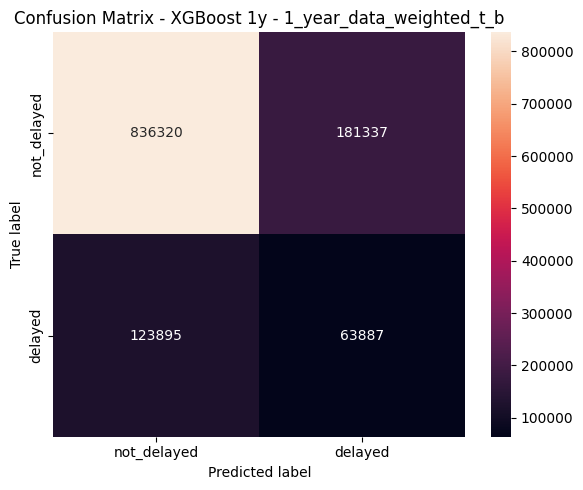

In [0]:
# XGBoost 1y model evaluations
cm_xg_1y = []
for model in xg_models_1y:
    _, _, _, _, cm = evaluate_model(model["model"], model["pred_test"], f"XGBoost 1y - {model['name']}")
    cm_xg_1y.append(cm)

=== Random Forest 1y - 1_year_data_weighted_t_b ===
Test accuracy : 0.7249
Test F1-score: 0.7458
Test precision: 0.7739
Test recall   : 0.7249


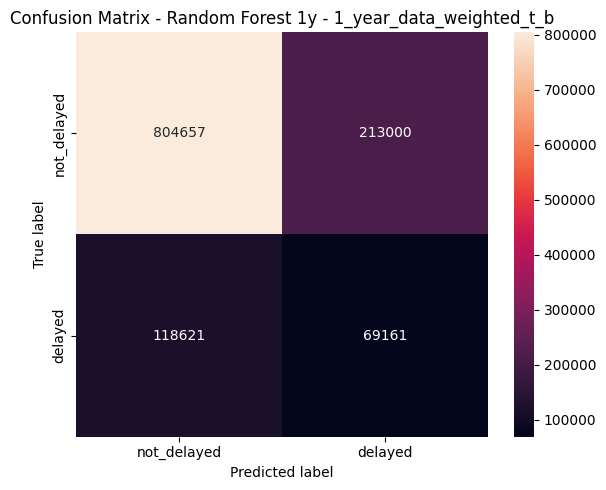

In [0]:
# Random Forest 1y model evaluations
cm_rf_1y = []
for model in rf_models_1y:
    _, _, _, _, cm = evaluate_model(model["model"], model["pred_test"], f"Random Forest 1y - {model['name']}")
    cm_rf_1y.append(cm)

## Cross Validation

In [0]:
def rolling_quarter_cv(df, quarter_split_function, cols_to_remove, start_quarter=1, end_quarter=4, chosen_cols=None):
    """
    - Full dataframe or target dataframe
    - Quarter split function
    - Columns to remove from the dataframe
    - Start quarter for rolling CV
    - End quarter for rolling CV
    - Chosen columns for modeling
    """
    results = []
    for test_quarter in range(start_quarter, end_quarter):
        # Use get_train_test_filter_df for train/test split
        split_df = get_train_test_filter_df(
            df, 
            quarter_split_function, 
            cols_to_remove, 
            test_quarter,
            test_quarter + 1, 
            chosen_cols
        )

        items = {
            "name": f"train_{test_quarter}_qtrs-test_qtr_{test_quarter + 1}",
            "train_df":  split_df["train_df"],
            "test_df":  split_df["test_df"],
            "feature_cols":  split_df["feature_cols"],
        }
        results.append(items)

    return results

In [0]:
def prepare_cv_pipeline(dfs, cols_to_remove, target):
    cv_datasets = []
    for df in dfs:
        res = rolling_quarter_cv(
            df,
            quarter_split,
            cols_to_remove,
            1,
            3,
            target
        )
        cv_datasets.extend(res)

    return cv_datasets

cv_dataset = prepare_cv_pipeline(dfs_1y, cols_to_remove, target_selected)

In [0]:
for cv in cv_dataset:
    print(cv["name"])

train_1_qtrs-test_qtr_2
train_2_qtrs-test_qtr_3


In [0]:
xg_cv = train_models(cv_dataset, train_xgboost, "weighted_xgboost_model__bin_t_qtr_cv")
rf_cv = train_models(cv_dataset, train_random_forest, "weighted_rf_model_bin_t_qtr_cv")

Loaded model from dbfs:/student-groups/Group_4_1/weighted_xgboost_model__bin_t_qtr_cv/train_1_qtrs-test_qtr_2
Loaded predictions from dbfs:/student-groups/Group_4_1/weighted_xgboost_model__bin_t_qtr_cv/train_1_qtrs-test_qtr_2_pred_test
Loaded training time from dbfs:/student-groups/Group_4_1/weighted_xgboost_model__bin_t_qtr_cv/train_1_qtrs-test_qtr_2_train_time.txt: 29.405596017837524
Loaded model from dbfs:/student-groups/Group_4_1/weighted_xgboost_model__bin_t_qtr_cv/train_2_qtrs-test_qtr_3
Loaded predictions from dbfs:/student-groups/Group_4_1/weighted_xgboost_model__bin_t_qtr_cv/train_2_qtrs-test_qtr_3_pred_test
Loaded training time from dbfs:/student-groups/Group_4_1/weighted_xgboost_model__bin_t_qtr_cv/train_2_qtrs-test_qtr_3_train_time.txt: 54.5403573513031
Loaded model from dbfs:/student-groups/Group_4_1/weighted_rf_model_bin_t_qtr_cv/train_1_qtrs-test_qtr_2
Loaded predictions from dbfs:/student-groups/Group_4_1/weighted_rf_model_bin_t_qtr_cv/train_1_qtrs-test_qtr_2_pred_test


In [0]:
# for i in rf_cv:
#     delete_model_if_exists("dbfs:/student-groups/Group_4_1/weighted_rf_model_bin_t_qtr_cv", i["name"])

# for i in xg_cv:
#     delete_model_if_exists("dbfs:/student-groups/Group_4_1/weighted_xgboost_model__bin_t_qtr_cv", i["name"])

In [0]:
def rolling_evaluation(model_results, eval_fn, title_prefix=""):
    """
    Evaluate each CV split using eval_fn(model, pred_test, title).
    Returns a list of dicts with cv_name and individual metrics for CV calculation.
    """
    metrics = []
    for res in model_results:
        title = f"{title_prefix}{res['name']}"
        acc, f1, prec, rec, cm = eval_fn(res["model"], res["pred_test"], title)
        metrics.append({
            "cv_name": res["name"],
            "accuracy": acc,
            "f1": f1,
            "precision": prec,
            "recall": rec,
            "confusion_matrix": cm
        })
    return metrics

=== XGBoost CV - train_1_qtrs-test_qtr_2 ===
Test accuracy : 0.6819
Test F1-score: 0.7046
Test precision: 0.7394
Test recall   : 0.6819


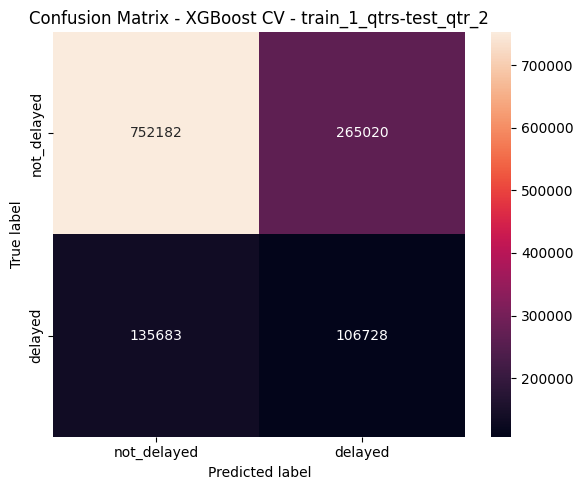

=== XGBoost CV - train_2_qtrs-test_qtr_3 ===
Test accuracy : 0.5870
Test F1-score: 0.6355
Test precision: 0.7830
Test recall   : 0.5870


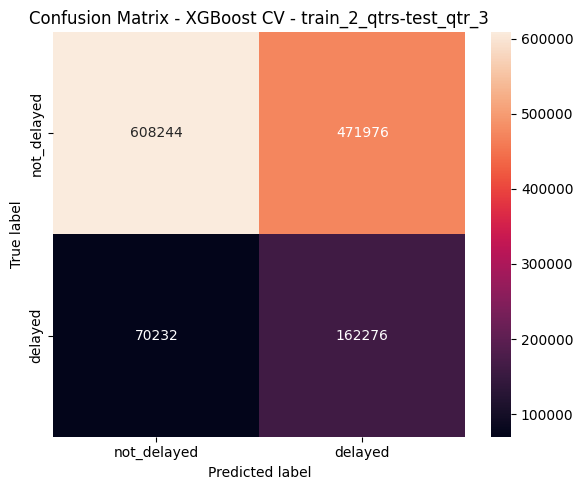

=== Random Forest CV - train_1_qtrs-test_qtr_2 ===
Test accuracy : 0.6903
Test F1-score: 0.7046
Test precision: 0.7226
Test recall   : 0.6903


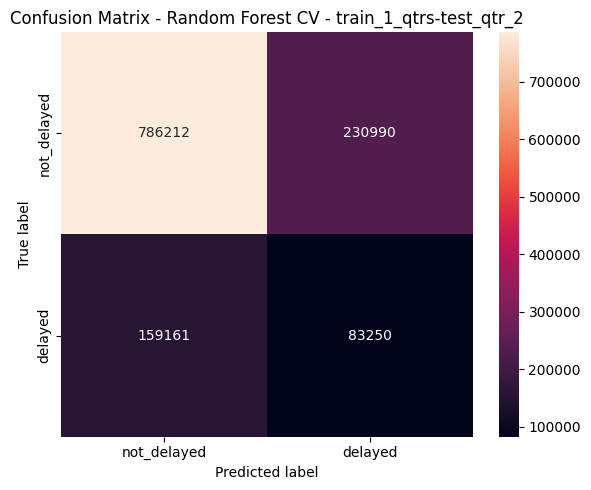

=== Random Forest CV - train_2_qtrs-test_qtr_3 ===
Test accuracy : 0.5927
Test F1-score: 0.6408
Test precision: 0.7778
Test recall   : 0.5927


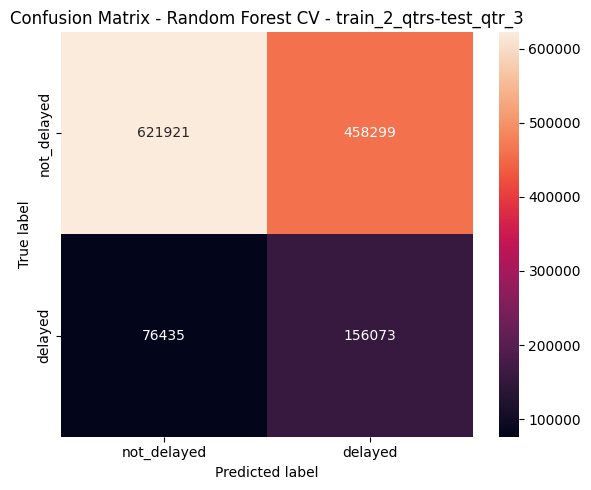

In [0]:
xg_cv_metrics = rolling_evaluation(xg_cv, evaluate_model, title_prefix="XGBoost CV - ")
rf_cv_metrics = rolling_evaluation(rf_cv, evaluate_model, title_prefix="Random Forest CV - ")

In [0]:
# Convert metrics lists to DataFrame for aggregation
xg_cv_metrics_df = pd.DataFrame(xg_cv_metrics)
rf_cv_metrics_df = pd.DataFrame(rf_cv_metrics)

# Compute mean for each metric
xg_cv_avg_metrics = xg_cv_metrics_df[["accuracy", "f1", "precision", "recall"]].mean()
rf_cv_avg_metrics = rf_cv_metrics_df[["accuracy", "f1", "precision", "recall"]].mean()

print("XGBoost CV average metrics:")
print(xg_cv_avg_metrics)

print("\nRandom Forest CV average metrics:")
print(rf_cv_avg_metrics)

XGBoost CV average metrics:
accuracy     0.634422
f1           0.670044
precision    0.761206
recall       0.634422
dtype: float64

Random Forest CV average metrics:
accuracy     0.641458
f1           0.672670
precision    0.750195
recall       0.641458
dtype: float64


## Confusion matrix for specific class

In [0]:
def precision_recall_f1_accuracy_for_class(cls, cm):
    TP = cm[cls, cls]
    FN = cm[cls, :].sum() - TP
    FP = cm[:, cls].sum() - TP
    TN = cm.sum() - TP - FN - FP

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) > 0 else 0

    return precision, recall, f1, accuracy

In [0]:
print(cm_xg_1y)

[array([[836320, 181337],
       [123895,  63887]])]


In [0]:
# DM for field delayed
for i in range(len(cm_xg_1y)):
    res_delay_xg_1y = precision_recall_f1_accuracy_for_class(1, cm_xg_1y[i])

    res_delay_rf_1y = precision_recall_f1_accuracy_for_class(1, cm_rf_1y[i])

In [0]:
res_delay_xg_cv = []
for i in xg_cv_metrics:
    res = precision_recall_f1_accuracy_for_class(1, i["confusion_matrix"])
    res_delay_xg_cv.append(res)

res_delay_rf_cv = []
for i in rf_cv_metrics:
    res = precision_recall_f1_accuracy_for_class(1, i["confusion_matrix"])
    res_delay_rf_cv.append(res)

In [0]:
report_metrics = lambda x: f"Precision: {x[0]}, Recall: {x[1]}, F1: {x[2]}, Accuracy: {x[3]}"

report_metrics(res_delay_xg_1y)

'Precision: 0.2605250709555345, Recall: 0.3402189773247702, F1: 0.295085980332836, Accuracy: 0.7467876848185598'

In [0]:
report_metrics(res_delay_rf_1y)

'Precision: 0.2451118333150223, Recall: 0.3683047363432065, F1: 0.2943378239488619, Accuracy: 0.7248960752057964'

In [0]:
# Get all metrics of a certain obs, then sum and finally take the average
def get_summary_of_cv(metrics):
    precision = []
    recall = []
    f1 = []
    accuracy = []

    for i in metrics:
        precision.append(i[0])
        recall.append(i[1])
        f1.append(i[2])
        accuracy.append(i[3])

    p = sum(precision) / len(precision)
    r = sum(recall) / len(recall)
    f = sum(f1) / len(f1)
    a = sum(accuracy) / len(accuracy)

    print(report_metrics((p, r, f, a)))

In [0]:
get_summary_of_cv(res_delay_xg_cv)

Precision: 0.27147592567384027, Recall: 0.5691071627052066, F1: 0.3610004789651158, Accuracy: 0.6344224663185261


In [0]:
get_summary_of_cv(res_delay_rf_cv)

Precision: 0.2594807702309512, Recall: 0.5073418164751726, F1: 0.33384686049856643, Accuracy: 0.6414577979759499


Grid Search optimizations

In [0]:
def crossval_grid_search(
    cv_splits,
    base_train_fn,
    param_grid,
    evaluate_fn,
    adjust_fns=None,
    maximize=True,
):
    if adjust_fns is None:
        adjust_fns = []

    param_names = list(param_grid.keys())
    param_values = [param_grid[k] for k in param_names]

    best_params = None
    best_score = None

    for values in product(*param_values):
        params = dict(zip(param_names, values))
        scores = []

        for split in cv_splits:
            train_df = split["train_df"]
            valid_df = split["test_df"]
            feats = split["feature_cols"]

            for fn in adjust_fns:
                train_df, valid_df = fn(train_df, valid_df)

            model, pred_valid = base_train_fn(train_df, valid_df, feats, **params)
            score = evaluate_fn(model, pred_valid, str(params))
            scores.append(score)

        mean_score = sum(scores) / len(scores)

        if best_score is None:
            is_better = True
        else:
            is_better = (mean_score > best_score) if maximize else (mean_score < best_score)

        if is_better:
            best_score = mean_score
            best_params = params

    return best_params, best_score


def train_random_forest_with_params(
    df_train,
    df_valid,
    features_col,
    label_col="DEP_DELAY_GROUP_CLASSIFIED",
    numTrees=150,
    maxDepth=8,
    maxBins=32,
    featureSubsetStrategy="auto",
    seed=42,
):
    stages = []
    stages.append(StringIndexer(inputCol=label_col, outputCol="label", handleInvalid="keep"))

    if isinstance(features_col, list):
        stages.append(VectorAssembler(inputCols=features_col, outputCol="features", handleInvalid="keep"))
        features_col_name = "features"
    else:
        features_col_name = features_col

    rf = RandomForestClassifier(
        featuresCol=features_col_name,
        labelCol="label",
        predictionCol="prediction",
        probabilityCol="probability",
        rawPredictionCol="rawPrediction",
        weightCol="class_weight",
        numTrees=numTrees,
        maxDepth=maxDepth,
        maxBins=maxBins,
        featureSubsetStrategy=featureSubsetStrategy,
        seed=seed,
    )
    stages.append(rf)

    rf_pipeline = Pipeline(stages=stages)
    rf_model = rf_pipeline.fit(df_train)
    pred_valid = rf_model.transform(df_valid)
    return rf_model, pred_valid


def random_forest_grid_search_cv(
    cv_splits,
    final_train_df,
    final_test_df,
    final_features_col,
    label_col="DEP_DELAY_GROUP_CLASSIFIED",
    param_grid=None,
    evaluate_fn=None,
    gs_save_path="",
    model_name="",
    adjust_fns=None,
    maximize=True,
):
    if adjust_fns is None:
        adjust_fns = []

    cache_enabled = (gs_save_path != "") and (model_name != "")
    if cache_enabled:
        base_path = f"{gs_save_path}/{model_name}"
        best_model_path = f"{base_path}/best_model"
        best_pred_path = f"{base_path}/best_pred_test"
        best_params_path = f"{base_path}/best_params.json"
        best_score_path = f"{base_path}/best_score.txt"
        time_save_path = f"{base_path}/train_time.txt"

        try:
            best_model = PipelineModel.load(best_model_path)
            best_pred_test = spark.read.parquet(best_pred_path)

            try:
                params_content = dbutils.fs.head(best_params_path, 10000)
                best_params = json.loads(params_content)
            except Exception:
                best_params = None

            try:
                score_content = dbutils.fs.head(best_score_path, 1000)
                best_score = float(score_content.strip())
            except Exception:
                best_score = None

            return best_model, best_pred_test, best_params, best_score

        except Exception:
            pass

    if param_grid is None:
        param_grid = {
            "numTrees": [100, 150],
            "maxDepth": [6, 8],
            "maxBins": [32],
            "featureSubsetStrategy": ["auto"],
        }

    if evaluate_fn is None:
        def evaluate_fn(m, pred, title):
            acc, f1, prec, rec, cm = evaluate_model(m, pred, title)
            return rec

    def base_train_fn(df_tr, df_va, feats, **params):
        return train_random_forest_with_params(df_tr, df_va, feats, label_col=label_col, **params)

    start_time = time.time()
    best_params, best_cv_score = crossval_grid_search(
        cv_splits=cv_splits,
        base_train_fn=base_train_fn,
        param_grid=param_grid,
        evaluate_fn=evaluate_fn,
        adjust_fns=adjust_fns,
        maximize=maximize,
    )

    train_df = final_train_df
    test_df = final_test_df
    for fn in adjust_fns:
        train_df, test_df = fn(train_df, test_df)

    best_model, best_pred_test = base_train_fn(train_df, test_df, final_features_col, **best_params)
    end_time = time.time()
    train_time = end_time - start_time

    if cache_enabled:
        base_path = f"{gs_save_path}/{model_name}"
        best_model_path = f"{base_path}/best_model"
        best_pred_path = f"{base_path}/best_pred_test"
        best_params_path = f"{base_path}/best_params.json"
        best_score_path = f"{base_path}/best_score.txt"
        time_save_path = f"{base_path}/train_time.txt"

        best_model.write().overwrite().save(best_model_path)
        best_pred_test.write.mode("overwrite").parquet(best_pred_path)
        dbutils.fs.put(best_params_path, json.dumps(best_params), overwrite=True)
        dbutils.fs.put(best_score_path, str(best_cv_score), overwrite=True)
        dbutils.fs.put(time_save_path, str(train_time), overwrite=True)

    return best_model, best_pred_test, best_params, best_cv_score


def train_xgboost_with_params(
    df_train,
    df_valid,
    features_col,
    label_col="DEP_DELAY_GROUP_CLASSIFIED",
    max_depth=6,
    n_estimators=100,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
):
    stages = []
    stages.append(StringIndexer(inputCol=label_col, outputCol="label", handleInvalid="keep"))

    if isinstance(features_col, list):
        stages.append(VectorAssembler(inputCols=features_col, outputCol="features", handleInvalid="keep"))
        features_col_name = "features"
    else:
        features_col_name = features_col

    xgb = SparkXGBClassifier(
        features_col=features_col_name,
        label_col="label",
        weight_col="class_weight",
        max_depth=max_depth,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha
    )
    stages.append(xgb)

    xgb_pipeline = Pipeline(stages=stages)
    xgb_model = xgb_pipeline.fit(df_train)
    pred_valid = xgb_model.transform(df_valid)
    return xgb_model, pred_valid


def xgboost_grid_search_cv(
    cv_splits,
    final_train_df,
    final_test_df,
    final_features_col,
    label_col="DEP_DELAY_GROUP_CLASSIFIED",
    param_grid=None,
    evaluate_fn=None,
    gs_save_path="",
    model_name="",
    adjust_fns=None,
    maximize=True,
):
    if adjust_fns is None:
        adjust_fns = []

    cache_enabled = (gs_save_path != "") and (model_name != "")
    if cache_enabled:
        base_path = f"{gs_save_path}/{model_name}"
        best_model_path = f"{base_path}/best_model"
        best_pred_path = f"{base_path}/best_pred_test"
        best_params_path = f"{base_path}/best_params.json"
        best_score_path = f"{base_path}/best_score.txt"
        time_save_path = f"{base_path}/train_time.txt"

        try:
            best_model = PipelineModel.load(best_model_path)
            best_pred_test = spark.read.parquet(best_pred_path)

            try:
                params_content = dbutils.fs.head(best_params_path, 10000)
                best_params = json.loads(params_content)
            except Exception:
                best_params = None

            try:
                score_content = dbutils.fs.head(best_score_path, 1000)
                best_score = float(score_content.strip())
            except Exception:
                best_score = None

            return best_model, best_pred_test, best_params, best_score

        except Exception:
            pass

    if param_grid is None:
        param_grid = {
            "max_depth": [4, 6],
            "n_estimators": [100, 150],
            "learning_rate": [0.05, 0.1],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0],
            "reg_lambda": [1.0, 2.0],
            "reg_alpha": [0.0, 1.0],
        }

    if evaluate_fn is None:
        def evaluate_fn(m, pred, title):
            acc, f1, prec, rec, cm = evaluate_model(m, pred, title)
            return rec

    def base_train_fn(df_tr, df_va, feats, **params):
        return train_xgboost_with_params(df_tr, df_va, feats, label_col=label_col, **params)

    start_time = time.time()
    best_params, best_cv_score = crossval_grid_search(
        cv_splits=cv_splits,
        base_train_fn=base_train_fn,
        param_grid=param_grid,
        evaluate_fn=evaluate_fn,
        adjust_fns=adjust_fns,
        maximize=maximize,
    )

    train_df = final_train_df
    test_df = final_test_df
    for fn in adjust_fns:
        train_df, test_df = fn(train_df, test_df)

    best_model, best_pred_test = base_train_fn(train_df, test_df, final_features_col, **best_params)
    end_time = time.time()
    train_time = end_time - start_time

    if cache_enabled:
        base_path = f"{gs_save_path}/{model_name}"
        best_model_path = f"{base_path}/best_model"
        best_pred_path = f"{base_path}/best_pred_test"
        best_params_path = f"{base_path}/best_params.json"
        best_score_path = f"{base_path}/best_score.txt"
        time_save_path = f"{base_path}/train_time.txt"

        best_model.write().overwrite().save(best_model_path)
        best_pred_test.write.mode("overwrite").parquet(best_pred_path)
        dbutils.fs.put(best_params_path, json.dumps(best_params), overwrite=True)
        dbutils.fs.put(best_score_path, str(best_cv_score), overwrite=True)
        dbutils.fs.put(time_save_path, str(train_time), overwrite=True)

    return best_model, best_pred_test, best_params, best_cv_score

In [0]:
final_train_df = df_split_1y[0]["train_df"]
final_test_df = df_split_1y[0]["test_df"]
final_features = df_split_1y[0]["feature_cols"]
split_name = df_split_1y[0]["name"]

adj_fns = [add_class_weights()]

rf_best_model, rf_best_pred_test, rf_best_params, rf_best_cv_recall = random_forest_grid_search_cv(
    cv_splits=cv_dataset,
    final_train_df=final_train_df,
    final_test_df=final_test_df,
    final_features_col=final_features,
    gs_save_path="dbfs:/student-groups/Group_4_1/rf_gs_cv",
    model_name=split_name,
    adjust_fns=adj_fns
)



RF best CV recall: 0.644409688522436
RF best params: {'numTrees': 100, 'maxDepth': 8, 'maxBins': 32, 'featureSubsetStrategy': 'auto'}
XGB best CV recall: 0.6396142267242536
XGB best params: {'max_depth': 6, 'n_estimators': 150, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_lambda': 2.0, 'reg_alpha': 1.0}
=== RF Final Test ===
Test accuracy : 0.7039
Test F1-score: 0.7330
Test precision: 0.7769
Test recall   : 0.7039


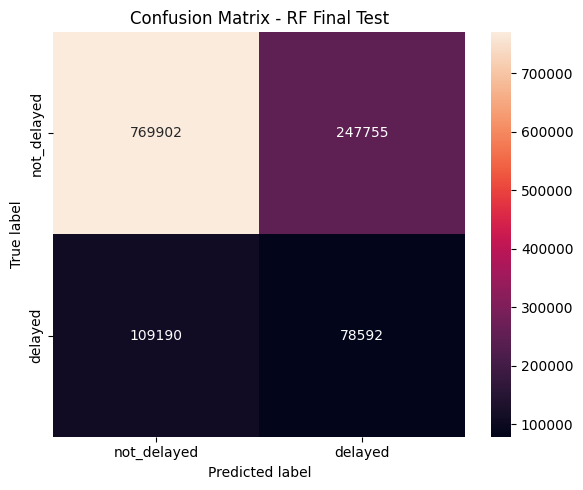

=== XGB Final Test ===
Test accuracy : 0.7433
Test F1-score: 0.7585
Test precision: 0.7775
Test recall   : 0.7433


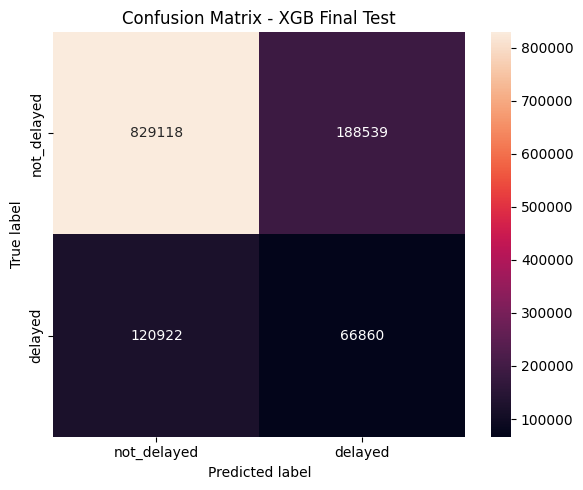

(0.7432794193650611,
 0.7584526905235432,
 0.7775486179874467,
 0.7432794193650611,
 array([[829118, 188539],
        [120922,  66860]]))

In [0]:
xgb_best_model, xgb_best_pred_test, xgb_best_params, xgb_best_cv_recall = xgboost_grid_search_cv(
    cv_splits=cv_dataset,
    final_train_df=final_train_df,
    final_test_df=final_test_df,
    final_features_col=final_features,
    gs_save_path="dbfs:/student-groups/Group_4_1/xgb_gs_cv",
    model_name=split_name,
    adjust_fns=adj_fns
)

print("RF best CV recall:", rf_best_cv_recall)
print("RF best params:", rf_best_params)

print("XGB best CV recall:", xgb_best_cv_recall)
print("XGB best params:", xgb_best_params)

# final test metrics (test_df was never used in GS)
evaluate_model(rf_best_model, rf_best_pred_test, "RF Final Test")
evaluate_model(xgb_best_model, xgb_best_pred_test, "XGB Final Test")

In [0]:
def train_best_random_forest(
    train_df,
    valid_df,
    features_col,
    label_col="DEP_DELAY_GROUP_CLASSIFIED",
    class_weight_fn=None,
    best_params=None,
):
    df_train, df_valid = train_df, valid_df
    if class_weight_fn is not None:
        df_train, df_valid = class_weight_fn(df_train, df_valid)
    params = best_params if best_params else rf_best_params
    return train_random_forest_with_params(
        df_train,
        df_valid,
        features_col,
        label_col=label_col,
        **params
    )

def train_best_xgboost(
    train_df,
    valid_df,
    features_col,
    label_col="DEP_DELAY_GROUP_CLASSIFIED",
    class_weight_fn=None,
    best_params=None,
):
    df_train, df_valid = train_df, valid_df
    if class_weight_fn is not None:
        df_train, df_valid = class_weight_fn(df_train, df_valid)
    params = best_params if best_params else xgb_best_params
    return train_xgboost_with_params(
        df_train,
        df_valid,
        features_col,
        label_col=label_col,
        **params
    )

def load_or_train_rf_model(train_df, valid_df, features_col, label_col, class_weight_fn, best_params, model_save_path):
    from pyspark.ml import PipelineModel
    import json
    import time

    model_path = f"{model_save_path}/best_model"
    pred_path = f"{model_save_path}/best_pred"
    params_path = f"{model_save_path}/best_params.json"
    time_path = f"{model_save_path}/train_time.txt"

    try:
        rf_model = PipelineModel.load(model_path)
        rf_pred = spark.read.parquet(pred_path)
        try:
            params_content = dbutils.fs.head(params_path, 10000)
            loaded_params = json.loads(params_content)
        except Exception:
            loaded_params = best_params
        try:
            train_time = float(dbutils.fs.head(time_path, 1000).strip())
        except Exception:
            train_time = None
        print(f"Loaded RF model from {model_path}. Train time: {train_time:.2f} seconds" if train_time else f"Loaded RF model from {model_path}")
        return rf_model, rf_pred, loaded_params, train_time
    except Exception:
        start_time = time.time()
        rf_model, rf_pred = train_best_random_forest(
            train_df, valid_df, features_col, label_col=label_col, class_weight_fn=class_weight_fn, best_params=best_params
        )
        end_time = time.time()
        train_time = end_time - start_time
        rf_model.write().overwrite().save(model_path)
        rf_pred.write.mode("overwrite").parquet(pred_path)
        dbutils.fs.put(params_path, json.dumps(best_params), overwrite=True)
        dbutils.fs.put(time_path, str(train_time), overwrite=True)
        print(f"Trained and saved RF model to {model_path}. Train time: {train_time:.2f} seconds")
        return rf_model, rf_pred, best_params, train_time

def load_or_train_xgb_model(train_df, valid_df, features_col, label_col, class_weight_fn, best_params, model_save_path):
    model_path = f"{model_save_path}/best_model"
    pred_path = f"{model_save_path}/best_pred"
    params_path = f"{model_save_path}/best_params.json"
    time_path = f"{model_save_path}/train_time.txt"

    try:
        xgb_model = PipelineModel.load(model_path)
        xgb_pred = spark.read.parquet(pred_path)
        try:
            params_content = dbutils.fs.head(params_path, 10000)
            loaded_params = json.loads(params_content)
        except Exception:
            loaded_params = best_params
        try:
            train_time = float(dbutils.fs.head(time_path, 1000).strip())
        except Exception:
            train_time = None
        print(f"Loaded XGB model from {model_path}. Train time: {train_time:.2f} seconds" if train_time else f"Loaded XGB model from {model_path}")
        return xgb_model, xgb_pred, loaded_params, train_time
    except Exception:
        start_time = time.time()
        xgb_model, xgb_pred = train_best_xgboost(
            train_df, valid_df, features_col, label_col=label_col, class_weight_fn=class_weight_fn, best_params=best_params
        )
        end_time = time.time()
        train_time = end_time - start_time
        xgb_model.write().overwrite().save(model_path)
        xgb_pred.write.mode("overwrite").parquet(pred_path)
        dbutils.fs.put(params_path, json.dumps(best_params), overwrite=True)
        dbutils.fs.put(time_path, str(train_time), overwrite=True)
        print(f"Trained and saved XGB model to {model_path}. Train time: {train_time:.2f} seconds")
        return xgb_model, xgb_pred, best_params, train_time

# Cross-validation set
cv_rf_models = []
cv_xgb_models = []
for idx, split in enumerate(cv_dataset):
    train_df = split["train_df"]
    valid_df = split["test_df"]
    feats = split["feature_cols"]
    split_name = split["name"]
    rf_save_path = f"dbfs:/student-groups/Group_4_1/rf_cv_models/{split_name}"
    xgb_save_path = f"dbfs:/student-groups/Group_4_1/xgb_cv_models/{split_name}"

    rf_model, rf_pred, _, rf_train_time = load_or_train_rf_model(
        train_df, valid_df, feats, "DEP_DELAY_GROUP_CLASSIFIED", add_class_weights(), rf_best_params, rf_save_path
    )
    xgb_model, xgb_pred, _, xgb_train_time = load_or_train_xgb_model(
        train_df, valid_df, feats, "DEP_DELAY_GROUP_CLASSIFIED", add_class_weights(), xgb_best_params, xgb_save_path
    )
    cv_rf_models.append((rf_model, rf_pred, rf_train_time))
    cv_xgb_models.append((xgb_model, xgb_pred, xgb_train_time))

# Dry run set (final split)
dry_rf_save_path = f"dbfs:/student-groups/Group_4_1/rf_cv_models/dry_run"
dry_xgb_save_path = f"dbfs:/student-groups/Group_4_1/xgb_cv_models/dry_run"

dry_rf_model, dry_rf_pred, best_params_rf, dry_rf_train_time = load_or_train_rf_model(
    final_train_df, final_test_df, final_features, "DEP_DELAY_GROUP_CLASSIFIED", add_class_weights(), rf_best_params, dry_rf_save_path
)
dry_xgb_model, dry_xgb_pred, best_params_xg, dry_xgb_train_time = load_or_train_xgb_model(
    final_train_df, final_test_df, final_features, "DEP_DELAY_GROUP_CLASSIFIED", add_class_weights(), xgb_best_params, dry_xgb_save_path
)

Loaded RF model from dbfs:/student-groups/Group_4_1/rf_cv_models/train_1_qtrs-test_qtr_2/best_model. Train time: 126.25 seconds
Loaded XGB model from dbfs:/student-groups/Group_4_1/xgb_cv_models/train_1_qtrs-test_qtr_2/best_model. Train time: 155.84 seconds
Loaded RF model from dbfs:/student-groups/Group_4_1/rf_cv_models/train_2_qtrs-test_qtr_3/best_model. Train time: 636.09 seconds
Loaded XGB model from dbfs:/student-groups/Group_4_1/xgb_cv_models/train_2_qtrs-test_qtr_3/best_model. Train time: 212.16 seconds
Loaded RF model from dbfs:/student-groups/Group_4_1/rf_cv_models/dry_run/best_model. Train time: 258.89 seconds
Loaded XGB model from dbfs:/student-groups/Group_4_1/xgb_cv_models/dry_run/best_model. Train time: 98.71 seconds


In [0]:
# for split in cv_dataset:
#     rf_save_path = f"dbfs:/student-groups/Group_4_1/rf_cv_models/{split['name']}"
#     xgb_save_path = f"dbfs:/student-groups/Group_4_1/xgb_cv_models/{split['name']}"
#     delete_model_if_exists(rf_save_path, "best_model")
#     delete_model_if_exists(xgb_save_path, "best_model")

# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_cv_models/dry_run", "best_model")
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgb_cv_models/dry_run", "best_model")

In [0]:
print("Best Random Forest parameters:", rf_best_params)
print("Best XGBoost parameters:", xgb_best_params)

Best Random Forest parameters: {'numTrees': 100, 'maxDepth': 8, 'maxBins': 32, 'featureSubsetStrategy': 'auto'}
Best XGBoost parameters: {'max_depth': 6, 'n_estimators': 150, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_lambda': 2.0, 'reg_alpha': 1.0}


=== RF Best Param CV - train_1_qtrs-test_qtr_2 ===
Test accuracy : 0.6963
Test F1-score: 0.7065
Test precision: 0.7185
Test recall   : 0.6963


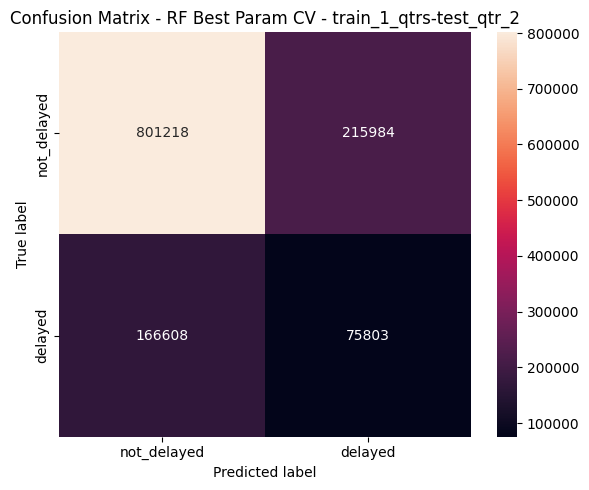

=== XGB Best Param CV - train_1_qtrs-test_qtr_2 ===
Test accuracy : 0.6801
Test F1-score: 0.7037
Test precision: 0.7408
Test recall   : 0.6801


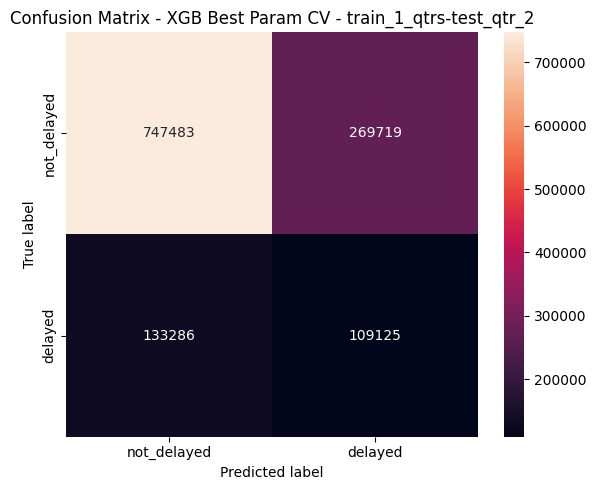

=== RF Best Param CV - train_2_qtrs-test_qtr_3 ===
Test accuracy : 0.5874
Test F1-score: 0.6360
Test precision: 0.7782
Test recall   : 0.5874


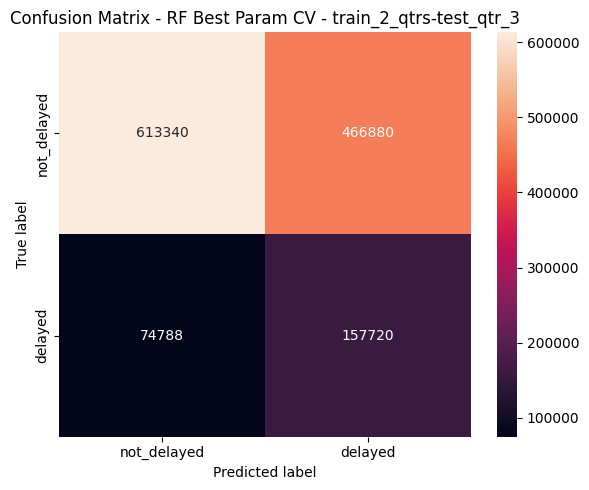

=== XGB Best Param CV - train_2_qtrs-test_qtr_3 ===
Test accuracy : 0.5949
Test F1-score: 0.6427
Test precision: 0.7828
Test recall   : 0.5949


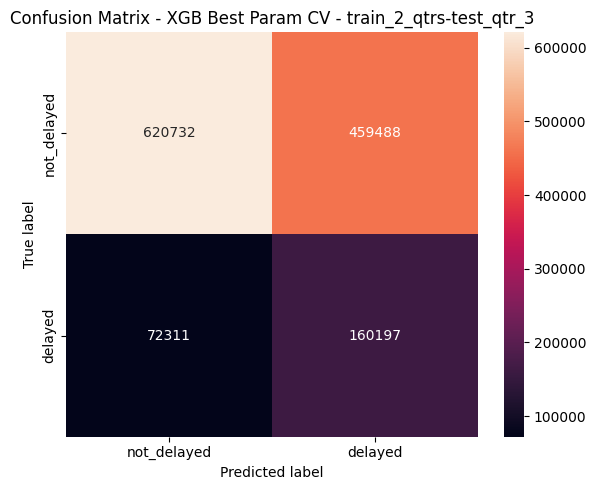

=== RF Best Param 1 Year ===
Test accuracy : 0.7074
Test F1-score: 0.7353
Test precision: 0.7768
Test recall   : 0.7074


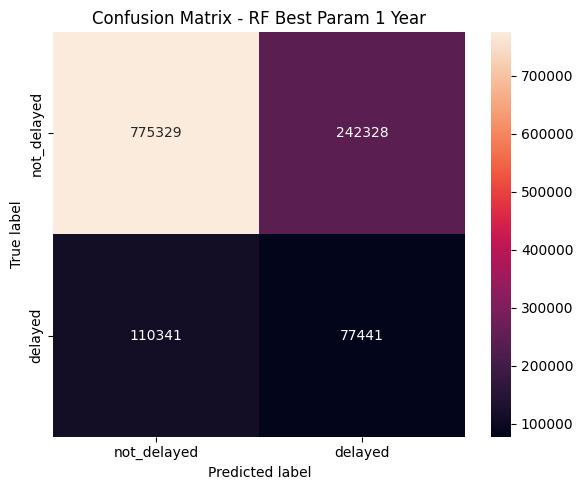

=== XGB Best Param 1 Year ===
Test accuracy : 0.7422
Test F1-score: 0.7576
Test precision: 0.7769
Test recall   : 0.7422


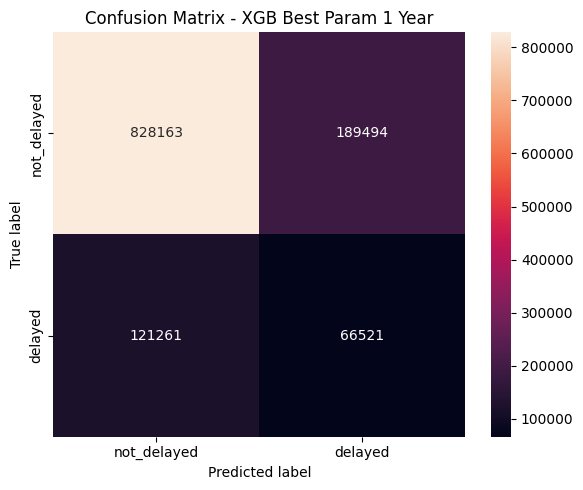

In [0]:
# Evaluate CV splits with best param models
cv_rf_metrics = []
cv_xgb_metrics = []
for idx, split in enumerate(cv_dataset):
    rf_model, rf_pred, _ = cv_rf_models[idx]
    xgb_model, xgb_pred, _ = cv_xgb_models[idx]
    rf_metrics = evaluate_model(rf_model, rf_pred, f"RF Best Param CV - {split['name']}")
    xgb_metrics = evaluate_model(xgb_model, xgb_pred, f"XGB Best Param CV - {split['name']}")
    cv_rf_metrics.append(rf_metrics)
    cv_xgb_metrics.append(xgb_metrics)

# Evaluate dry run (final split) with best param models
dry_rf_metrics = evaluate_model(dry_rf_model, dry_rf_pred, "RF Best Param 1 Year")
dry_xgb_metrics = evaluate_model(dry_xgb_model, dry_xgb_pred, "XGB Best Param 1 Year")

best results above

=== RF Original Train - train_1_qtrs-test_qtr_2 ===
Test accuracy : 0.6643
Test F1-score: 0.6945
Test precision: 0.7572
Test recall   : 0.6643


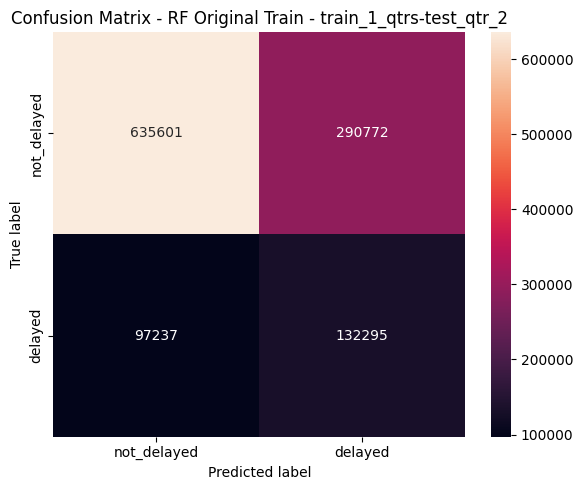

=== RF Original Train - train_2_qtrs-test_qtr_3 ===
Test accuracy : 0.6365
Test F1-score: 0.6728
Test precision: 0.7581
Test recall   : 0.6365


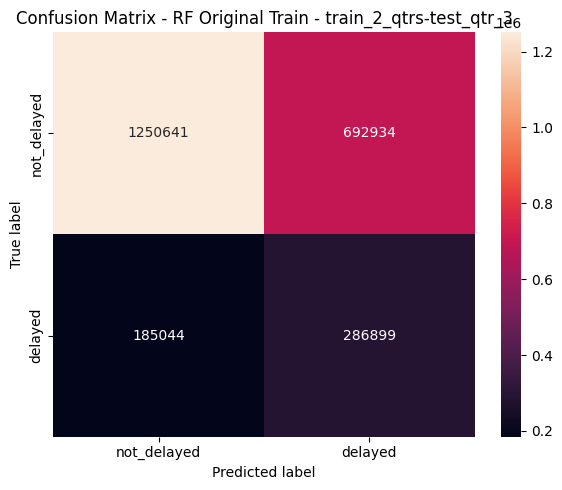

=== XGB Original Train - train_1_qtrs-test_qtr_2 ===
Test accuracy : 0.6712
Test F1-score: 0.7024
Test precision: 0.7781
Test recall   : 0.6712


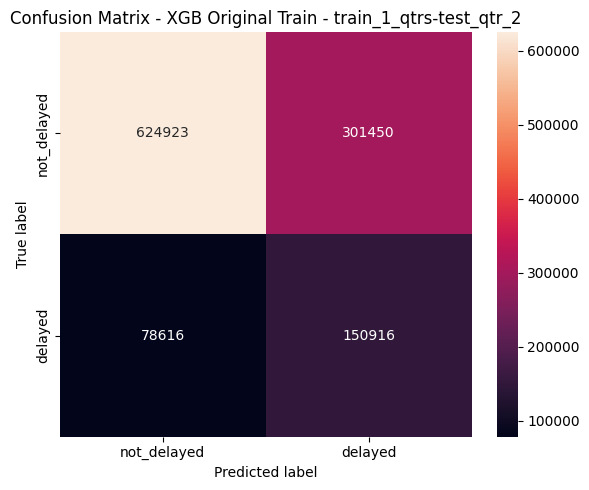

=== XGB Original Train - train_2_qtrs-test_qtr_3 ===
Test accuracy : 0.6499
Test F1-score: 0.6852
Test precision: 0.7769
Test recall   : 0.6499


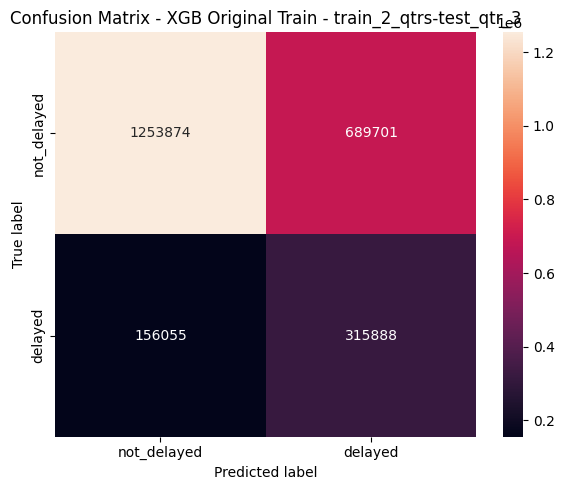

=== RF Best Param Train - train_1_qtrs-test_qtr_2 ===
Test accuracy : 0.6699
Test F1-score: 0.6989
Test precision: 0.7573
Test recall   : 0.6699


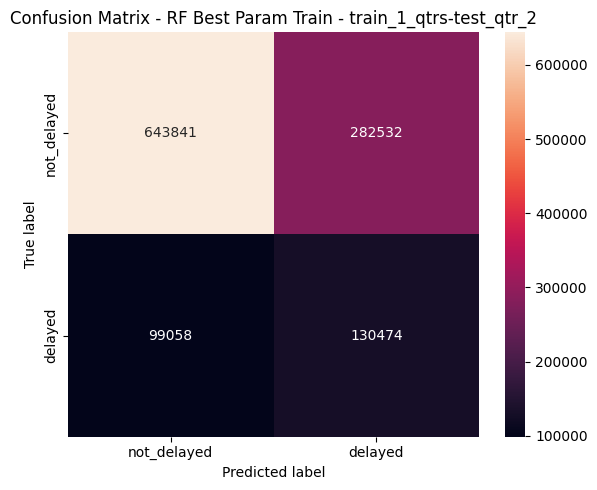

=== XGB Best Param Train - train_1_qtrs-test_qtr_2 ===
Test accuracy : 0.6776
Test F1-score: 0.7080
Test precision: 0.7816
Test recall   : 0.6776


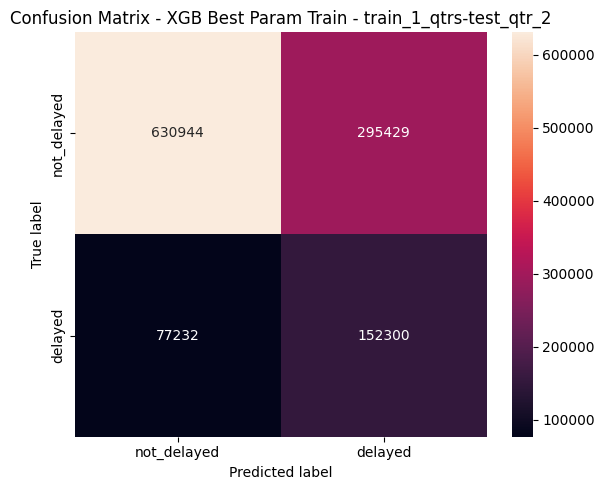

=== RF Best Param Train - train_2_qtrs-test_qtr_3 ===
Test accuracy : 0.6362
Test F1-score: 0.6726
Test precision: 0.7587
Test recall   : 0.6362


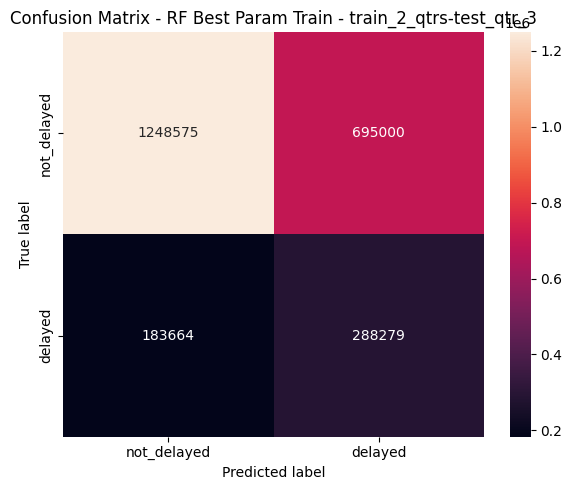

=== XGB Best Param Train - train_2_qtrs-test_qtr_3 ===
Test accuracy : 0.6578
Test F1-score: 0.6921
Test precision: 0.7799
Test recall   : 0.6578


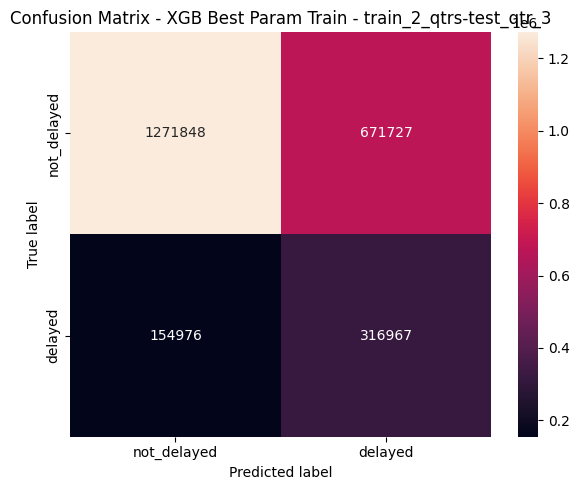

=== RF Best Param Train - Dry Run ===
Test accuracy : 0.6291
Test F1-score: 0.6686
Test precision: 0.7670
Test recall   : 0.6291


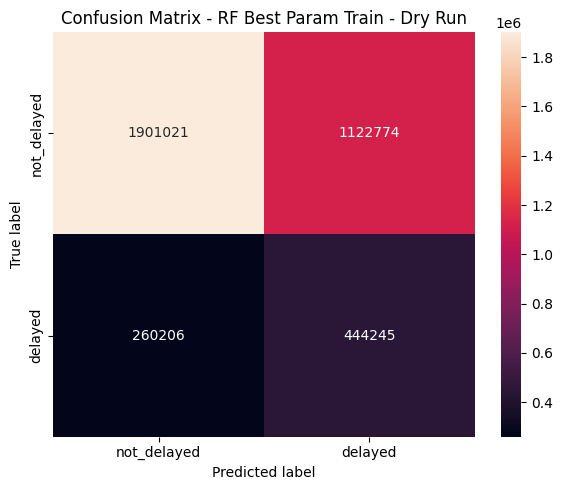

=== XGB Best Param Train - Dry Run ===
Test accuracy : 0.6537
Test F1-score: 0.6903
Test precision: 0.7836
Test recall   : 0.6537


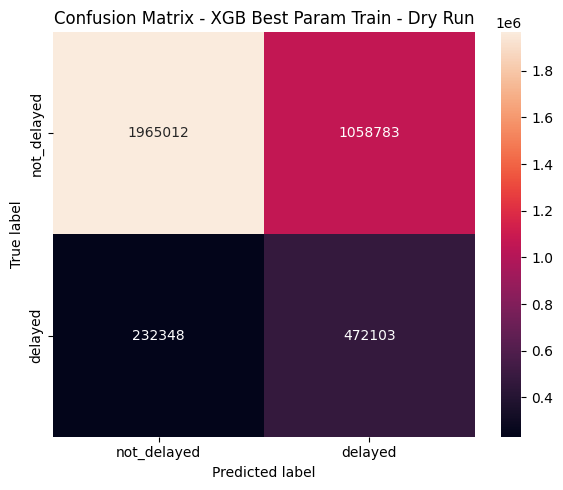

In [0]:
# Rebuild training data if not available
if 'final_train_df' not in locals() or final_train_df is None:
    final_train_df = spark.read.parquet("dbfs:/student-groups/Group_4_1/final_train_df.parquet")

# Compute metrics and confusion matrix for original models
orig_rf_train_metrics = []
orig_xgb_train_metrics = []
orig_rf_conf_matrices = []
orig_xgb_conf_matrices = []

for idx, res in enumerate(rf_cv):
    model = res["model"]
    split = cv_dataset[idx]
    train_df = split["train_df"]
    name = res.get("name", f"exp_{idx}")
    if model is not None and train_df is not None:
        metrics = evaluate_model(model, model.transform(train_df), f"RF Original Train - {name}")
        orig_rf_train_metrics.append(metrics)
        orig_rf_conf_matrices.append(metrics[-1])

for idx, res in enumerate(xg_cv):
    model = res["model"]
    split = cv_dataset[idx]
    train_df = split["train_df"]
    name = res.get("name", f"exp_{idx}")
    if model is not None and train_df is not None:
        metrics = evaluate_model(model, model.transform(train_df), f"XGB Original Train - {name}")
        orig_xgb_train_metrics.append(metrics)
        orig_xgb_conf_matrices.append(metrics[-1])

# Cross-validation models (best param per fold)
cv_rf_train_metrics = []
cv_xgb_train_metrics = []
cv_rf_conf_matrices = []
cv_xgb_conf_matrices = []

for idx, split in enumerate(cv_dataset):
    rf_model, _, _ = cv_rf_models[idx]
    xgb_model, _, _ = cv_xgb_models[idx]
    train_df = split["train_df"]
    name = split.get("name", f"cv_fold_{idx}")
    if rf_model is not None and train_df is not None:
        metrics = evaluate_model(rf_model, rf_model.transform(train_df), f"RF Best Param Train - {name}")
        cv_rf_train_metrics.append(metrics)
        cv_rf_conf_matrices.append(metrics[-1])
    if xgb_model is not None and train_df is not None:
        metrics = evaluate_model(xgb_model, xgb_model.transform(train_df), f"XGB Best Param Train - {name}")
        cv_xgb_train_metrics.append(metrics)
        cv_xgb_conf_matrices.append(metrics[-1])

# Optimized model (dry run)
dry_rf_train_metrics = evaluate_model(dry_rf_model, dry_rf_model.transform(final_train_df), "RF Best Param Train - Dry Run")
dry_xgb_train_metrics = evaluate_model(dry_xgb_model, dry_xgb_model.transform(final_train_df), "XGB Best Param Train - Dry Run")
dry_rf_conf_matrix = dry_rf_train_metrics[-1]
dry_xgb_conf_matrix = dry_xgb_train_metrics[-1]



=== RF Best Param Train - Dry Run ===
Test accuracy : 0.6291
Test F1-score: 0.6686
Test precision: 0.7670
Test recall   : 0.6291


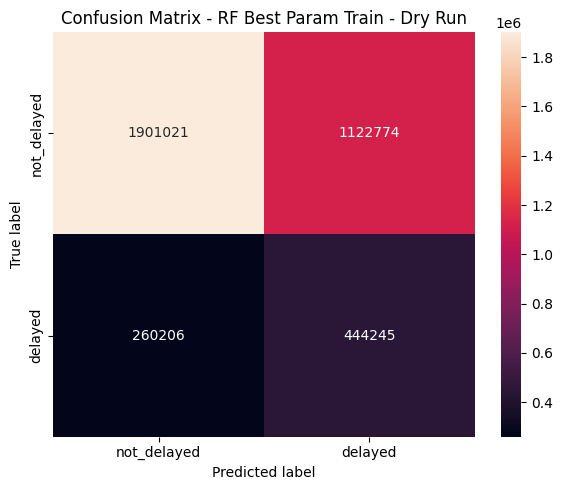

=== XGB Best Param Train - Dry Run ===
Test accuracy : 0.6537
Test F1-score: 0.6903
Test precision: 0.7836
Test recall   : 0.6537


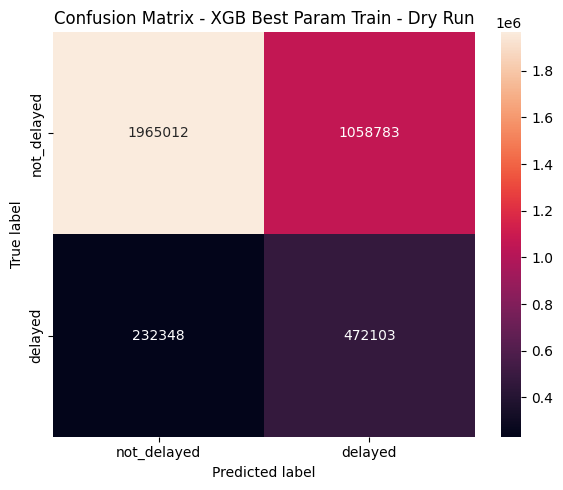


--- RF train metrics (dry run) ---


accuracy,f1,precision,recall
0.6290534476534005,0.668630172419082,0.7669686393555589,0.6290534476534005



--- RF train confusion matrix (dry run) ---


array([[1901021, 1122774],
       [ 260206,  444245]])


--- XGB train metrics (dry run) ---


accuracy,f1,precision,recall
0.6536894292919512,0.6902992998001197,0.783559490117637,0.6536894292919512



--- XGB train confusion matrix (dry run) ---


array([[1965012, 1058783],
       [ 232348,  472103]])

In [0]:
# Compute metrics and confusion matrix for train data using best param models
rf_train_metrics = evaluate_model(dry_rf_model, dry_rf_model.transform(final_train_df), "RF Best Param Train - Dry Run")
xgb_train_metrics = evaluate_model(dry_xgb_model, dry_xgb_model.transform(final_train_df), "XGB Best Param Train - Dry Run")

import pandas as pd

print("\n--- RF train metrics (dry run) ---")
display(pd.DataFrame([rf_train_metrics[:-1]], columns=["accuracy", "f1", "precision", "recall"]))
print("\n--- RF train confusion matrix (dry run) ---")
display(rf_train_metrics[-1])

print("\n--- XGB train metrics (dry run) ---")
display(pd.DataFrame([xgb_train_metrics[:-1]], columns=["accuracy", "f1", "precision", "recall"]))
print("\n--- XGB train confusion matrix (dry run) ---")
display(xgb_train_metrics[-1])

=== XGBoost 1Y Train - 1_year_data_weighted_t_b ===
Test accuracy : 0.6475
Test F1-score: 0.6850
Test precision: 0.7814
Test recall   : 0.6475


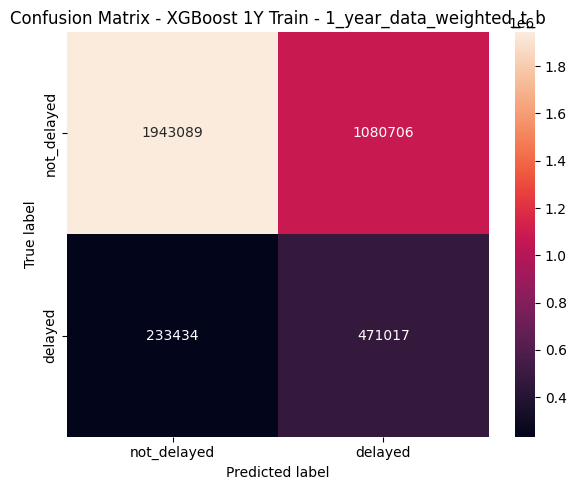

(0.6475178944737016, 0.6849881356873208, 0.7814190828134959, 0.6475178944737017, array([[1943089, 1080706],
       [ 233434,  471017]]))


In [0]:
# Evaluate XGBoost models on their respective training splits for 1-year window
xgb_train_metrics_1y = []
for i, split in enumerate(df_split_1y):
    model = xg_models_1y[i]["model"] if isinstance(xg_models_1y[i], dict) else xg_models_1y[i]
    train_df = split["train_df"]
    pred_train = model.transform(train_df)
    metrics = evaluate_model(
        model,
        pred_train,
        f"XGBoost 1Y Train - {split['name']}"
    )
    xgb_train_metrics_1y.append(metrics)

# Display the metrics for each split
for m in xgb_train_metrics_1y:
    print(m)

=== Random Forest 1Y Train - 1_year_data_weighted_t_b ===
Test accuracy : 0.6306
Test F1-score: 0.6699
Test precision: 0.7665
Test recall   : 0.6306


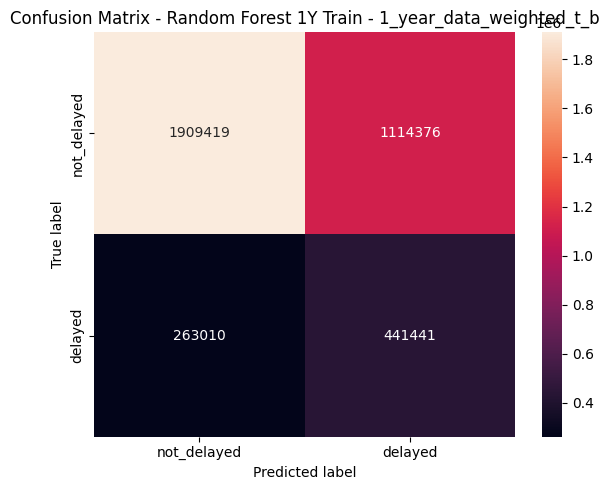

(0.6305538851245331, 0.6698671535952824, 0.7664704630860542, 0.6305538851245331, array([[1909419, 1114376],
       [ 263010,  441441]]))


In [0]:
# Evaluate Random Forest models on their respective training splits for 1-year window
rf_train_metrics_1y = []
for i, split in enumerate(df_split_1y):
    model = rf_models_1y[i]["model"] if isinstance(rf_models_1y[i], dict) else rf_models_1y[i]
    train_df = split["train_df"]
    pred_train = model.transform(train_df)
    metrics = evaluate_model(
        model,
        pred_train,
        f"Random Forest 1Y Train - {split['name']}"
    )
    rf_train_metrics_1y.append(metrics)

# Display the metrics for each split
for m in rf_train_metrics_1y:
    print(m)

=== XGB Best Param Train - Train Set ===
Test accuracy : 0.6537
Test F1-score: 0.6903
Test precision: 0.7836
Test recall   : 0.6537


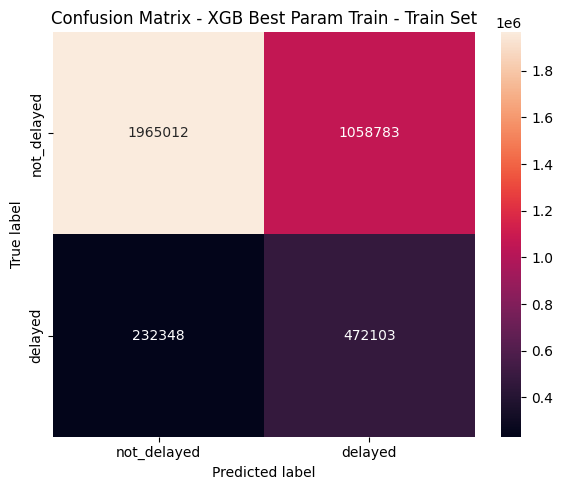


--- XGB train metrics (dry run) ---


accuracy,f1,precision,recall
0.6536894292919512,0.6902992998001197,0.783559490117637,0.6536894292919512



--- XGB train confusion matrix (dry run) ---


array([[1965012, 1058783],
       [ 232348,  472103]])

In [0]:
xgb_train_metrics = evaluate_model(dry_xgb_model, dry_xgb_model.transform(final_train_df), "XGB Best Param Train - Train Set")

print("\n--- XGB train metrics (dry run) ---")
display(pd.DataFrame([xgb_train_metrics[:-1]], columns=["accuracy", "f1", "precision", "recall"]))
print("\n--- XGB train confusion matrix (dry run) ---")
display(xgb_train_metrics[-1])

=== RF Best Param Train - Train Set ===
Test accuracy : 0.6291
Test F1-score: 0.6686
Test precision: 0.7670
Test recall   : 0.6291


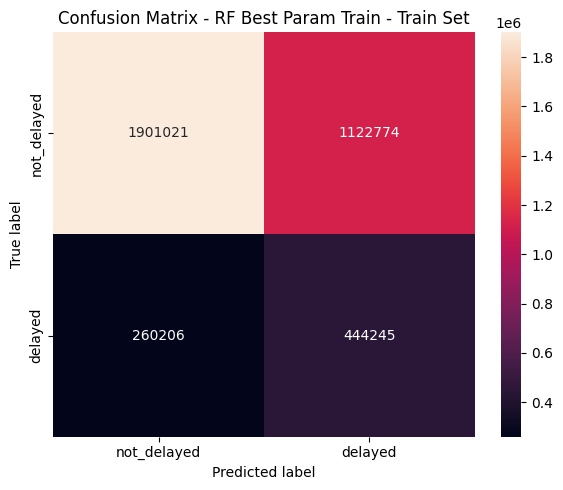


--- RF train metrics (dry run) ---


accuracy,f1,precision,recall
0.6290534476534005,0.668630172419082,0.7669686393555589,0.6290534476534005



--- RF train confusion matrix (dry run) ---


array([[1901021, 1122774],
       [ 260206,  444245]])

In [0]:
rf_train_metrics = evaluate_model(dry_rf_model, dry_rf_model.transform(final_train_df), "RF Best Param Train - Train Set")

print("\n--- RF train metrics (dry run) ---")
display(pd.DataFrame([rf_train_metrics[:-1]], columns=["accuracy", "f1", "precision", "recall"]))
print("\n--- RF train confusion matrix (dry run) ---")
display(rf_train_metrics[-1])